<a href="https://colab.research.google.com/github/rahul-ohlan/TWARP/blob/main/imdb_interpretabilityV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT LIBRARIES

In [338]:
# from google.colab import drive
# drive.mount("/gdrive/")
# %cd "/gdrive/"

In [339]:
import os
import random
import pickle
from timeit import default_timer as timer

import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight

# !pip install transformers --quiet
from transformers import TFAutoModel, BertTokenizerFast, BertModel
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.constraints import MaxNorm
import keras
from keras.layers import Input, Concatenate, Flatten, Embedding, Dense, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Lambda

[nltk_data] Downloading package punkt to
[nltk_data]     /home/rahul_fordham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rahul_fordham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LOAD AND PROCESS DATA

In [340]:
def SEED_EVERYTHING(seed_val):
  random.seed(seed_val)
  np.random.seed(seed_val)
  # torch.manual_seed(seed_val)
  # torch.cuda.manual_seed_all(seed_val)
  tf.random.set_seed(seed_val)
  return

seed = 47
SEED_EVERYTHING(seed)

In [341]:
def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
                      punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
                      stop_words = set(stopwords.words("english"))) -> list:  
    
        '''
        A method to preprocess text
        
        '''

        for x in text.lower():
            if x in punctuations:
                text = text.replace(x,"")
                
        # removing words that have numbers in them
        text = re.sub(r'\w*\d\w*', '', text)
        # remove digits
        text = re.sub(r'[0-9]+', ' ', text)
        
        # clean the whitespaces
        
        text = re.sub(r'\s+', ' ', text).strip()
        
        
        
        # convert all text to a list
        
        # text = text.split(' ').  # uncomment if list required
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text) # no emoji

        # lowercase eth
        
        text = text.lower()
        
        
        # drop the stop words
        

        
        # add the tags

        return text

In [342]:
# IMDB Dataset
# dataframe = pd.read_csv('/gdrive/Shareddrives/Thesis/datasets/IMDB_Dataset.csv')
dataframe = pd.read_csv("../datasets/imdb/IMDB_Dataset.csv")
dataframe["sentiment"] = dataframe["sentiment"].apply(lambda x : 1.0 if x == "positive" else 0.0)
dataframe = dataframe.sample(frac = 1, random_state = 47).reset_index(drop = True)
dataframe["review"] = dataframe["review"].apply(lambda x : text_preprocessing(x))
dataframe

,review,sentiment
0,cleos second husband is an amateurish attempt ...,0.0
1,first of all i would like to clarify that i co...,0.0
2,volcano is set in los angeles where a minor ea...,0.0
3,this must have been one of chaplins most ambit...,1.0
4,military training films are becoming so common...,1.0
...,...,...
49995,happenstance is the most new yorkfeeling paris...,1.0
49996,this film tried to capitalize on the much bett...,1.0
49997,another of many nearly forgotten movies cranke...,0.0
49998,few movies have dashed expectations and upset ...,0.0


In [343]:
# class imbalance?
dataframe["sentiment"].value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: sentiment, dtype: float64

In [344]:
# NO Apparent Class Imbalance

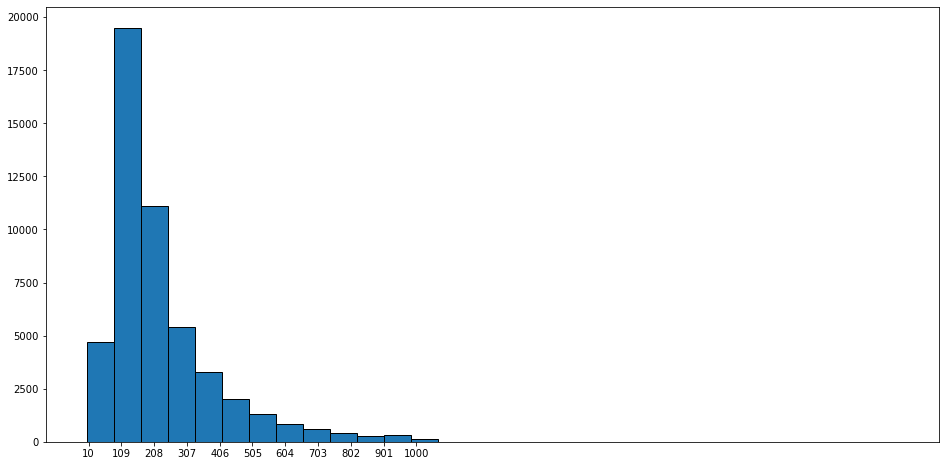

In [345]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["review"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,1000,11))
plt.show()

Considering only data with less < 128 tokens

In [346]:
dataframe["token_length"] = token_lengths
dataframe = dataframe.loc[dataframe["token_length"] <= 128, :].reset_index(drop=True)

In [347]:
dataframe.head()

,review,sentiment,token_length
0,cleos second husband is an amateurish attempt ...,0.0,47
1,this must have been one of chaplins most ambit...,1.0,126
2,well it might be a kids movieperhaps but im no...,1.0,89
3,i am a big fan of larkins works i believe that...,1.0,107
4,please give this one a missbr br kristy swanso...,0.0,65


In [348]:
# class imbalance?
dataframe["sentiment"].value_counts(normalize=True)

1.0    0.516664
0.0    0.483336
Name: sentiment, dtype: float64

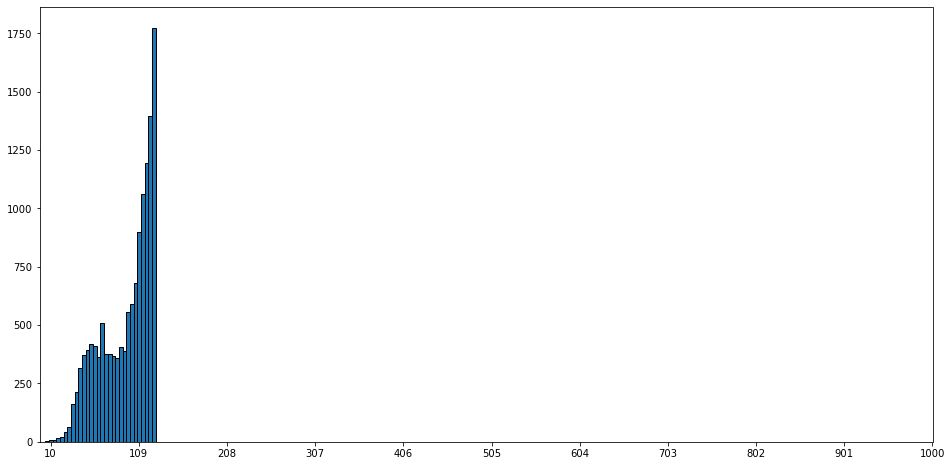

In [349]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["review"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,1000,11))
plt.show()

In [350]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [351]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, temp_df = train_test_split(dataframe, test_size= 0.30, stratify= dataframe["sentiment"], random_state = 47)

val_df,   test_df   = train_test_split(temp_df, test_size= 0.50, stratify= temp_df["sentiment"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
test_df  = test_df.reset_index(drop = True)

In [352]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [353]:
bertModel.summary()

Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [354]:
# dataset generator (for input to tf.data.Dataset.from_generator())

class dataset:
  
  def __init__(self,text,labels,max_length, tokenizer,projection_dim, val = False):

    self.text =   text
    self.labels = labels
    self.max_length = max_length
    self.tokenizer = tokenizer
    self.flag = val
    self.projection_dim = projection_dim

  def __len__(self):

    return  self.text.shape[0]

  def __getitem__(self,index):

    sentence = self.text[index]
    category = self.labels[index]

    return sentence, category
    

  # shuffle the dataset after each epoch
  def on_epoch_end(self):

    random_idx = random.sample(list(range(self.__len__())), k = self.__len__())
    self.text   = self.text[random_idx]
    self.labels = self.labels[random_idx]

  def __call__(self):

    for i in range(self.__len__()):
      sentence, label = self.__getitem__(i)
      encodings = self.tokenizer(sentence,
                                 max_length = self.max_length,
                                 padding = "max_length",
                                 truncation = True)
      
      input_ids  = np.array(encodings["input_ids"])
      masks      = np.array(encodings["attention_mask"])
      ttids      = np.array(encodings["token_type_ids"])

      embedding_index = np.array([i for i in range(self.projection_dim)])
      embedding_index = np.ravel(embedding_index)

      embedding_index = np.tile(embedding_index, (input_ids[0:1].shape[0],))

      yield {"input_ids": input_ids, "attention_masks": masks,"space": embedding_index}, label
      
      # randomize the dataset on epoch end, only in case of training dataset
      if i == self.__len__() -1 and self.flag is False:
        self.on_epoch_end()

### Hyperparameters

In [355]:
MAX_LENGTH = 128
BATCH_SIZE = 32
PROJECTION_DIM = 10
VECTOR_DIM = 768

In [356]:
# create generators for train and validation
train_gen = dataset(train_df["review"].values,train_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
val_gen   = dataset(val_df["review"].values,val_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

In [357]:
# create tensorflow dataloaders from generators

train_ds = tf.data.Dataset.from_generator(train_gen,
                                            output_signature = 
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).repeat().batch(batch_size = BATCH_SIZE) # shuffling is already implemented in dataset class

val_ds = tf.data.Dataset.from_generator(val_gen,
                                            output_signature = 
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

### Miscellaneous

In [358]:
# HOW TO REPLACE A VALUE WITHIN A TENSOR BY INDICES OR BY VALUE
# https://stackoverflow.com/questions/42883415/how-to-replace-a-value-within-a-tensor-by-indices?noredirect=1&lq=1

# import tensorflow as tf

# x = tf.constant([[4.0, 43.0, 45.0],
#                  [2.0, 22.0, 6664.0],
#                  [-4543.0, 0.0, 43.0]])
# value = 45.0
# indices = [1, 1]

# by_indices = tf.tensor_scatter_nd_update(x, [indices], [value])
# tf.print('Using indices\n', by_indices, '\n')

# by_value = tf.where(tf.equal(x, 22.0), value, x)
# tf.print('Using value\n', by_value)

## AUXILLIARY FUNCTIONS

In [359]:
# NA
def return_embedding_index(x_train,count):
  
  embedding_index=np.array([i for i in range(count)])

  embeding_index=np.ravel(embedding_index) # flattens the array

  rank = len(x_train.shape)
  if rank < 3:
    embedding_index = np.tile(embedding_index,(x_train[0:1].shape[0],1,)) 
  else:
    embedding_index = np.tile(embedding_index,(x_train.shape[0],1,))

  return embedding_index


# cosine similarity b/w two vectors
def cosine_similarity_projected(vects):

  x,w=vects                             
                                                                                                             
  dp = tf.matmul(x, w)   
                         
  
  x_mag = tf.norm(x, axis=2, keepdims = True)  

  w_mag = tf.norm(w,axis = 1, keepdims = True)

  denominator = dp / x_mag
  cosine = denominator / w_mag

  return cosine

# NA
def compare_cosine(vector):

  peace,violent=vector    

  peace=tf.math.reduce_mean(peace, axis=1)      
  violent=tf.math.reduce_mean(violent, axis=1)   
  out=tf.concat([peace,violent],axis=-1)       
  print("COMPARE-COSINE")
  print('out.shape')
  print(out.shape)    


  return out   

# NA
# takes mean embeddings
class remove_pads(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_pads,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  

  
  
  def call(self,listInputs):  

    inputs = listInputs[0]
    input_ids = listInputs[1]
    masks = self.mask_generator.compute_mask(input_ids)     
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)    
    temp = tf.unstack(masks,axis=1)
    del temp[0]
    temp.insert(0,tf.zeros_like(temp[0]))
    masks = tf.stack(temp,axis=1)
    length = tf.math.reduce_sum(masks,axis = 1, keepdims=True)     # (None,1,1)
    # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300)
    # take SUM, (not mean)
    masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True) 
    # now just divide each by the length to get mean of non zero embeddings
    masked_embeddings = masked_embeddings / length   
                                                    
    return masked_embeddings



class remove_padsV2(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_padsV2,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words

  
  
  def call(self,listInputs):   

    inputs = listInputs[0]                   # (None,MAX_LENGTH,PROJECTION_DIM)
    input_ids = listInputs[1]                # (None,MAX_LENGTH)

    # convert token ids 101 and 102 to 0
    filteredInputIds = tf.where(tf.equal(input_ids,101) | tf.equal(input_ids,102),0,input_ids)
    # get masks for input ids
    masks = self.mask_generator.compute_mask(filteredInputIds)
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)    # (None,MAX_LENGTH,1)

    masked_embeddings = inputs * masks  

    return masked_embeddings



# mean embeddings
def merge_function(vects):

  positive, negative = vects[0], vects[1]    # (None,MAX_LENGTH,PROJECTION_DIM)


  # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0
  # we sum them up and then divide with number of non-zeros to get average cosine similarities
  positiveLength = tf.math.count_nonzero(tf.math.reduce_sum(positive, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)   # (None,1,1)
  negativeLength = tf.math.count_nonzero(tf.math.reduce_sum(negative, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)

  # now obtain average of cosine similarities
  positive = tf.math.reduce_sum(positive,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
  positiveAverage = tf.divide(positive, positiveLength)

  negative = tf.math.reduce_sum(negative,axis=1, keepdims=True)    # (None,1,PROJECTION_DIM)
  negativeAverage = tf.divide(negative, negativeLength)


    
  # input_shape = (None,1,Projection_DIM)
  res = tf.concat([positiveAverage,negativeAverage], axis = -1)    # (None,1,PROJECTION_DIM)

  return res


# max embeddings
def merge_functionV2(vects):

  positive, negative = vects[0], vects[1]   
  # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0


  # TAKE MAXIMUM COSINE SIMILARITY OF ALL THE TOKENS OF A SENTENCE WRT EACH PROJECTION DIM
  positiveMax = tf.reduce_max(positive, axis=1, keepdims=True)     # (None, 1, PROJECTION_DIM)
  negativeMax = tf.reduce_max(negative, axis=1, keepdims=True)

    
  res = tf.concat([positiveMax,negativeMax], axis = -1)            # (None,1,  2 * PROJECTION_DIM)

  return res

## MODEL ARCHITECTURE

In [360]:
# Model Debugging - Rahul
DEBUG = "DEBUG"

# for input we have
# 1. input ids
# 2. attention_masks
# 3. embedding_index (PROJECTION_DIM)
# 4. label

# first two will go to bert as input
ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "input_ids")
mks = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "attention_masks")
projection_space = layers.Input(name = "space", shape = (PROJECTION_DIM,))


input_sentence = bertModel(ids, attention_mask = mks)[0]                        # layers freezed, last_hidden_state_output


positive_embedding_layer =  layers.Embedding(name = "positive_embedding",
                                   input_dim = PROJECTION_DIM, 
                                   output_dim=VECTOR_DIM, 
                                   embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.), 
                                   input_length = PROJECTION_DIM , 
                                   trainable=True, 
                                   mask_zero=True)


negative_embedding_layer =  layers.Embedding(name = "negative_embedding",
                                   input_dim=PROJECTION_DIM, 
                                   output_dim=VECTOR_DIM, 
                                   embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.), 
                                   input_length = PROJECTION_DIM , 
                                   trainable=True, 
                                   mask_zero=True)


# embeddings for projection space
positive_embedding_np = positive_embedding_layer(projection_space)              # (None,PROJECTION_DIM,VECTOR_DIM)
negative_embedding_np = negative_embedding_layer(projection_space)              # (None,PROJECTION_DIM,VECTOR_DIM)

#Permute
positive_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(positive_embedding_np)           
negative_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(negative_embedding_np)           


# pos_projection_space
positive_cosine = layers.Lambda(function=cosine_similarity_projected, 
                      name='cosine_positive')([input_sentence, positive_embedding])              # (None,MAX_LENGTH,PROJECTION_DIM)


# neg_projection_space
negative_cosine = layers.Lambda(function=cosine_similarity_projected, 
                         name='cosine_negative')([input_sentence, negative_embedding])          
              


# remove paddings from cosines from both layers
positive_cosine_nopads = remove_padsV2(name="remove_cls_pad_positive")([positive_cosine, ids])   # (None,MAX_LENGTH,PROJECTION_DIM)
negative_cosine_nopads = remove_padsV2(name="remove_cls_pad_negative")([negative_cosine, ids])   



# merge (v1: mean, v2: max)
merged = layers.Lambda(function=merge_functionV2, 
                name='TakeMaxCosineAndCompare')([positive_cosine_nopads, negative_cosine_nopads])  # (None,1,1002)    # !these values are not really identical beacause both embedding layers had different random weights

merged = layers.Flatten(data_format = "channels_first")(merged)

# CLASSIFICATION HEAD

hidden = layers.Dense(256, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(merged)                                 

hidden = layers.Dropout(0.25, name="drop-1")(hidden)
hidden = layers.Dense(64, activation='relu', name = "hidden-2", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-2")(hidden)
hidden = layers.Dense(16, activation='relu', name = "hidden-3", kernel_constraint=MaxNorm(3),
               kernel_initializer= "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-3")(hidden)


predictions = layers.Dense(1, activation= "sigmoid" , name='classification_layer')(hidden)              

model = Model(inputs=[ids, mks, projection_space],outputs= predictions)

In [361]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 space (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 positive_embedding (Embedding)  (None, 10, 768)     7680        ['space[0][0]']                  
                                                                                           

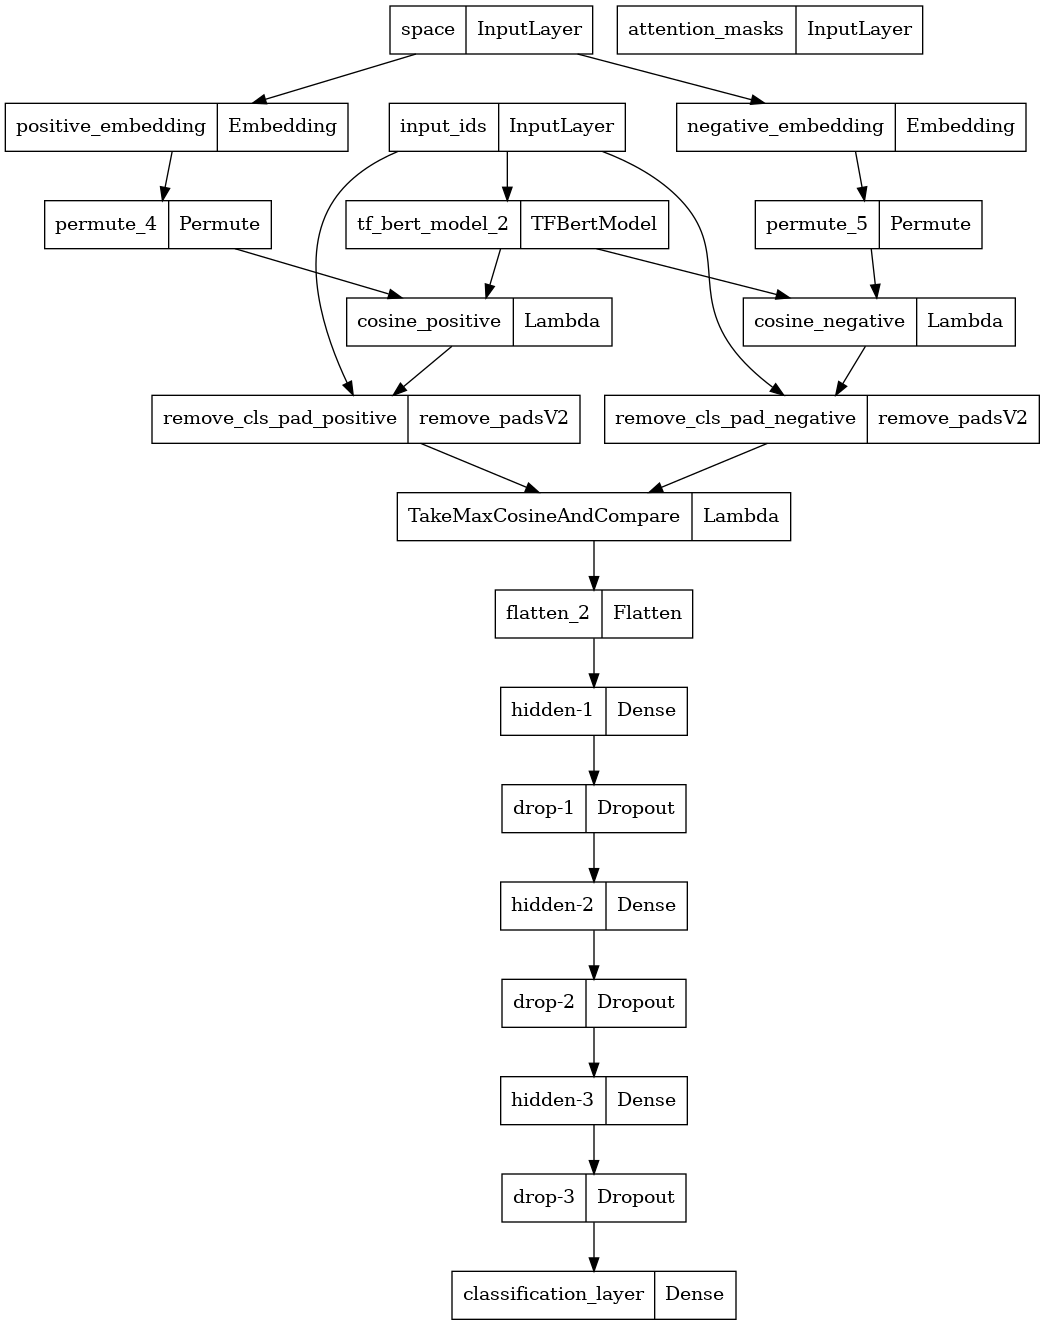

In [362]:
# from keras.utils import plot_model
# tf.keras.utils.plot_model(model,to_file = "/content/sample_data/something.png", show_shapes=False)
tf.keras.utils.plot_model(model,to_file = "./something.png", show_shapes=False)

## MODEL TRAINING

### Loss Functions


In [363]:
# reduce similarity among projection spaces
projection_loss = tf.keras.losses.CosineSimilarity()(tf.math.reduce_mean(positive_cosine, axis=1), tf.math.reduce_mean(negative_cosine, axis=1))
model.add_loss((1.0/(1.01 + projection_loss)))


# increase stdDevLoss in projection dimension
def StdDevLoss(x):                                                              # (None,MAX_LEN,PROJECTION_DIM)

  stdDev = tf.math.reduce_std(x,axis=2)                                         # (None,MAX_LEN)
  stdDevLoss = tf.math.reduce_mean(stdDev) 

  return stdDevLoss


posStdDevLoss = StdDevLoss(positive_cosine)
negStdDevLoss = StdDevLoss(negative_cosine)

# model.add_loss(1.0 / (posStdDevLoss + 0.001))
# model.add_loss(1.0 / (negStdDevLoss + 0.001))

model.add_loss(-1 * posStdDevLoss)
model.add_loss(-1 * negStdDevLoss)

# cross entropy loss
crossEntropLoss = tf.keras.losses.BinaryCrossentropy(from_logits = False)


# optimize can compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, clipnorm = 1.0)
model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])

In [364]:
# mini batches per epoch
len(train_gen) // BATCH_SIZE

300

In [365]:
# BASE_PATH = "/gdrive/Shareddrives/Thesis/"
BASE_PATH = "./saved_models/"

### Callbacks

In [366]:
# uncomment while training:

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= BASE_PATH + "imdb_bestWeightsV3.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True)

In [367]:
# EPOCHS = 15
# history = model.fit(
#     train_ds,
#     steps_per_epoch = len(train_gen) // BATCH_SIZE,
#     validation_data = val_ds,
#     epochs = EPOCHS,
#     callbacks = [modelcheckpoint]
# )

### Save training history

In [368]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

# with open(f"{BASE_PATH}/imdb_training_historyV3.pkl","wb") as hist:
#   pickle.dump(history.history,hist)

### Load Weights

In [369]:
model.load_weights(f"{BASE_PATH}imdb_bestWeightsV3.h5")

## MODEL EVALUATION

In [370]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["review"].values,test_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [371]:
test_df.head()

,review,sentiment,token_length
0,alien was excellent many writers tried to copy...,0.0,121
1,miscasting happens susannah yorke is a luminou...,0.0,122
2,there was a bugs bunny cartoon titled baby bug...,0.0,116
3,watched out of verneuil sober drama about a we...,0.0,78
4,this is a really good flick with awesome humor...,1.0,120


In [372]:
test_df.shape

(2062, 3)

In [373]:
# convert sigmoid outputs to labels
def predictionLabels(i):

  if i < 0.5:
    return 0.0
  else:
    return 1.0

getLabels = np.vectorize(predictionLabels)

In [374]:
predictions = model.predict(test_ds)

In [375]:
predictedLabels = getLabels(predictions)
predictedLabels.shape

(2062, 1)

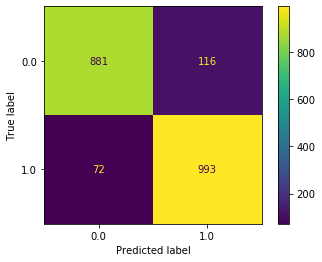

In [376]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

confusion_matrix(test_df.sentiment.values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df.sentiment.values, predictedLabels)

In [377]:
print(classification_report(test_df.sentiment.values, predictedLabels))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       997
         1.0       0.90      0.93      0.91      1065

    accuracy                           0.91      2062
   macro avg       0.91      0.91      0.91      2062
weighted avg       0.91      0.91      0.91      2062



## **`LIME`** MODEL INTERPRETABILITY

In [378]:
# ...

## **`TWARP`** MODEL INTERPRETABILITY

In [379]:
neg_reviews = test_df.loc[test_df.sentiment == 0.0].reset_index(drop=True)
pos_reviews = test_df.loc[test_df.sentiment == 1.0].reset_index(drop=True)

In [380]:
pos_reviews

,review,sentiment,token_length
0,this is a really good flick with awesome humor...,1.0,120
1,i just finished watching this last weekend and...,1.0,107
2,disneys buena vista pictures presents a wonder...,1.0,111
3,a brief history of time the cosmological conte...,1.0,126
4,wow i loved this movie this film was filled wi...,1.0,109
...,...,...,...
1060,this trash version of `romeo and juliet passes...,1.0,119
1061,having obtained a copy of bostocks cup i must ...,1.0,110
1062,robert urich was a fine actor and he makes thi...,1.0,111
1063,a drifter looking for a job is mistaken for a ...,1.0,122


In [381]:
r = np.random.randint(1065)
print(r)
pos_reviews.iloc[r,0]

327


'the movie is great like every other international project that includes strong impressions three of them israel bosnia and egypt shouldve been cut out especially bosnian clip which is pathetic beyond all reason and doesnt contain a single original thought or element on its own everything else is really great unrecognizable for most of americans known for the rest of the world unfortunately clips speak about misery of the people all over the world and as i see it there are so many of those who wont give a damn about itbr br top loach penn inarritu lalouche imamura'

In [382]:
neg_reviews

,review,sentiment,token_length
0,alien was excellent many writers tried to copy...,0.0,121
1,miscasting happens susannah yorke is a luminou...,0.0,122
2,there was a bugs bunny cartoon titled baby bug...,0.0,116
3,watched out of verneuil sober drama about a we...,0.0,78
4,humm an italian movie starred by david hasselh...,0.0,109
...,...,...,...
992,humm an italian movie starred by david hasselh...,0.0,109
993,very funny to watch berettas island as kind of...,0.0,87
994,warning this review may contain spoilers the b...,0.0,82
995,really i cant believe that i spent on this mov...,0.0,123


In [383]:
r = np.random.randint(997)
print(r)
neg_reviews.iloc[r,0]

264


'autobiography of founder of zoo in nyc starts out by being very cute and would be great family movie if it stayed there however we get more and more involved with reality as gorilla grows up to be a wild thing not easily amenable to his mothers wishes this might scare younger children esp scenes where buddy tries to injure gertrude rather quick resolution at the end below average'

In [384]:
layer_outputs = [layer.output for layer in model.layers]
len(layer_outputs)

49

In [385]:
layer_outputs[2]

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'attention_masks')>

In [386]:
# get latent vector representations -- 7th layer of model2
layer_outputs = [layer.output for layer in model.layers]

activation_model_pos = Model(inputs = model.input, outputs = model.get_layer("remove_cls_pad_positive").output)   # (None,128,300)
activation_model_neg = Model(inputs = model.input, outputs = model.get_layer("remove_cls_pad_negative").output)   # (None,128,300)

In [387]:
cpostitives = activation_model_pos.predict(test_ds)

In [388]:
cpostitives.shape

(2062, 128, 10)

In [389]:
# testing again
for ele in test_ds.take(1):
  tempout = ele

In [390]:
t_ids = tempout[0]["input_ids"]
t_attmasks = tempout[0]["attention_masks"]
t_spaceids = tempout[0]["space"]

In [391]:
t_ids

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  7344,  2001, ...,  2507,  2009,   102],
       [  101, 28616, 10526, ..., 15867,  2000,   102],
       [  101,  2045,  2001, ...,   102,     0,     0],
       ...,
       [  101,  1045,  2245, ...,  2593, 17522,   102],
       [  101,  7021,  2023, ...,  2017,  2021,   102],
       [  101,  2023,  3185, ...,     0,     0,     0]], dtype=int32)>

In [392]:
test_df.iloc[0]

review          alien was excellent many writers tried to copy...
sentiment                                                     0.0
token_length                                                  121
Name: 0, dtype: object

In [393]:
tokenizer.batch_decode(t_ids)[0]

'[CLS] alien was excellent many writers tried to copy it they all did a bad job or almost but dead space is the worst alien copy because of the bad actors the bad special effects the bad scenario and other bad stuff it would take about pages to tell everything that is bad in this film the movie wasnt very long and this is a very good thing the only one you cannot laugh because it is too seriousthat is a bad thing because in almost each bseries scifi film you can laugh during the whole time it can be terrific sometimes but instead of watching this stupidity just watch alien or event horizonthese are much better i give it [SEP]'

In [394]:
t_idsZerod = tf.where(tf.equal(t_ids,101) | tf.equal(t_ids,102),0,t_ids)
t_idsZerod

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[    0,  7344,  2001, ...,  2507,  2009,     0],
       [    0, 28616, 10526, ..., 15867,  2000,     0],
       [    0,  2045,  2001, ...,     0,     0,     0],
       ...,
       [    0,  1045,  2245, ...,  2593, 17522,     0],
       [    0,  7021,  2023, ...,  2017,  2021,     0],
       [    0,  2023,  3185, ...,     0,     0,     0]], dtype=int32)>

In [395]:
t_idsZerod[0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([    0,  7344,  2001,  6581,  2116,  4898,  2699,  2000,  6100,
        2009,  2027,  2035,  2106,  1037,  2919,  3105,  2030,  2471,
        2021,  2757,  2686,  2003,  1996,  5409,  7344,  6100,  2138,
        1997,  1996,  2919,  5889,  1996,  2919,  2569,  3896,  1996,
        2919, 11967,  1998,  2060,  2919,  4933,  2009,  2052,  2202,
        2055,  5530,  2000,  2425,  2673,  2008,  2003,  2919,  1999,
        2023,  2143,  1996,  3185,  2347,  2102,  2200,  2146,  1998,
        2023,  2003,  1037,  2200,  2204,  2518,  1996,  2069,  2028,
        2017,  3685,  4756,  2138,  2009,  2003,  2205,  3809,  8322,
        2102,  2003,  1037,  2919,  2518,  2138,  1999,  2471,  2169,
       18667, 28077, 16596,  8873,  2143,  2017,  2064,  4756,  2076,
        1996,  2878,  2051,  2009,  2064,  2022, 27547,  2823,  2021,
        2612,  1997,  3666,  2023, 28072,  2074,  3422,  7344,  2030,
        2724,  9154, 24138,  2063,  2024,  2

In [396]:
cpostitives[0][-2]

array([-0.5791753 ,  0.12685712, -0.12192855,  0.22897212, -0.0618756 ,
        0.4157636 ,  0.52619296,  0.09581851, -0.23882136, -0.0492584 ],
      dtype=float32)

In [397]:
# clearly cpostitives is getting us the correct output corresponding to an example

In [398]:
# take 32 examples from positive class and 32 from negative class (i.e a batch)
# then for each batch, get cpostitives and cnegatitives
# for postive batch:
# take first example and get top 10 tokens from it ranked in order of highest cosine similarites with 300  tokens from positive projection vector
# for same example take top 10 tokens from it ranked in order of highest average cosine simlarity with 300 tokens from negative projection vector

# now get their the embeddings of all 20 from bert, separately for 10
# plot all embeddings on a tSNE chart with different colors corresponding to projection spaces

In [399]:
def get_TFDataset(dataframe):

  data_gen   = dataset(dataframe["review"].values,dataframe["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
  data_ds = tf.data.Dataset.from_generator(data_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

  return data_ds

def getCosineSimlarities(MODEL, ds_object):

  activation_model_pos = Model(inputs = MODEL.input, outputs = MODEL.get_layer("remove_cls_pad_positive").output)   # (None,1,300)
  activation_model_neg = Model(inputs = MODEL.input, outputs = MODEL.get_layer("remove_cls_pad_negative").output)   # (None,1,300)
  # activation_model_bertEmbeddings = Model(inputs = MODEL.input, outputs = MODEL.get_layer("tf_bert_model").output[0])

  pos_cosine = activation_model_pos.predict(ds_object)
  neg_cosine = activation_model_neg.predict(ds_object)
  # bertEmbeddings = activation_model_bertEmbeddings.predict(ds_object)
  bertEmbeddings = None

  return pos_cosine, neg_cosine, bertEmbeddings

In [400]:
def Rand(start, end, num):
    res = []
 
    for j in range(num):
        res.append(random.randint(start, end))
 
    return res
 
# Driver Code
num = 100
start = 0
end = 950
random_nums = Rand(start,end,num)

In [401]:
# get the dataset object to be fed as input to model for making predictions
# pos_ds = get_TFDataset(pos_reviews[0:100])
pos_ds = get_TFDataset(pos_reviews.iloc[random_nums])

In [402]:
# get the dataset object to be fed as input to model for making predictions
# neg_ds = get_TFDataset(neg_reviews[0:100])
neg_ds = get_TFDataset(neg_reviews.iloc[random_nums])

In [403]:
# get cosine similarites of first batch of positive reviews with both projection spaces
posData_posProjSpace, posData_negProjSpace, posBertEmbeddings = getCosineSimlarities(model, pos_ds)

In [404]:
posData_posProjSpace.shape, posData_negProjSpace.shape

((100, 128, 10), (100, 128, 10))

In [405]:
negData_posProjSpace, negData_negProjSpace, negBertEmbeddings = getCosineSimlarities(model, neg_ds)

In [406]:
negData_posProjSpace.shape, negData_negProjSpace.shape

((100, 128, 10), (100, 128, 10))

In [407]:
# get all ids from batch dataset to a single tensor

# positive data
pos_ids = tf.zeros(shape = (0,128), dtype = tf.int32)
for ele in pos_ds:
  # print(ele[0]["input_ids"])
  pos_ids = tf.concat([pos_ids,ele[0]["input_ids"]], axis = 0)

# negative data
neg_ids = tf.zeros(shape = (0,128), dtype = tf.int32)
for ele in neg_ds:
  neg_ids = tf.concat([neg_ids, ele[0]["input_ids"]], axis=0)

In [408]:
pos_ids.shape, neg_ids.shape

(TensorShape([100, 128]), TensorShape([100, 128]))

In [409]:
# 100 sentences, top 10 tokens for each projection space with their cosine similarities

In [429]:
def ProjSpaceTokens(projSpace, inputids):

  numDocs = len(projSpace)

  DocDict = dict()
  for sentID in range(numDocs):

    sentence = pd.DataFrame(projSpace[sentID])
    sentence["tokens"] = tokenizer.batch_decode(inputids[sentID])

    res = dict()

    for index, col in enumerate(sentence.columns):
      if col != "tokens":
        res[col] = list()

        # first sort the column in descending order wrt cosine sim values\
        sortedBy_column = sentence.iloc[sentence[col].sort_values(ascending = False).index, :]
        # print(sortedBy_column)
        # print("*"*50)
        # sortedBy_columns is complete dataframe sorted in descending order of values by column = "col"; shape = (128,301)
        # now we we want to keep appending the top ten tokens to it if the token's cosine similarity is absolute maximum
        count = 1
        for row in sortedBy_column.values:

          token = row[-1]
          
          if count < 11 and token not in res[col]:
            res[col].append((token, np.round(row[col],4)))
            count+=1
    # now res contains top 10 tokens against each projection space dimension for each sentence of for loop
    DocDict[f"sentence {sentID+1}"] = pd.DataFrame(res).add_prefix("projDim_").rename_axis("tokens")
  
  return DocDict

In [430]:
posData_posSpace = ProjSpaceTokens(posData_posProjSpace, pos_ids)

In [431]:
negData_negSpace = ProjSpaceTokens(negData_negProjSpace, neg_ids)

In [433]:
posData_posSpace["sentence 1"]

,projDim_0,projDim_1,projDim_2,projDim_3,projDim_4,projDim_5,projDim_6,projDim_7,projDim_8,projDim_9
tokens,,,,,,,,,,
0,"([CLS], -0.0)","(is, 0.177)","([CLS], -0.0)","(this, 0.2739)","(superb, 0.1365)","(done, 0.4414)","(was, 0.5848)","(is, 0.1664)","([CLS], -0.0)","(this, 0.0814)"
1,"([SEP], -0.0)","(somewhat, 0.1607)","([SEP], -0.0)","(done, 0.2711)","(terrific, 0.1359)","(##ing, 0.4401)","(##ly, 0.5753)","(horrible, 0.1507)","([SEP], -0.0)","(these, 0.0388)"
2,"(##ho, -0.1874)","(disturbing, 0.1537)","(appeared, -0.0145)","(was, 0.266)","(fine, 0.1001)","(in, 0.4397)","(done, 0.5702)","(parts, 0.1377)","(better, -0.0301)","(this, 0.0381)"
3,"(##ja, -0.2192)","(horrific, 0.148)","(forget, -0.0145)","(the, 0.2645)","(well, 0.0967)","(just, 0.4338)","(a, 0.5662)","(one, 0.1365)","(horrific, -0.0401)","(fine, 0.0375)"
4,"(##the, -0.2682)","(horrible, 0.1414)","(terrific, -0.021)","(of, 0.2619)","(fine, 0.0603)","(were, 0.4311)","(is, 0.5542)","(immersed, 0.1359)","(screen, -0.0708)","(this, 0.0372)"
5,"(##the, -0.3215)","(##ly, 0.1345)","(briefly, -0.0289)","(a, 0.2612)","(a, 0.047)","(i, 0.4198)","(of, 0.5479)","(just, 0.1357)","(fine, -0.071)","(vo, 0.0365)"
6,"(vo, -0.3247)","(never, 0.1308)","(superb, -0.0338)","(terrific, 0.257)","(did, 0.041)","(was, 0.4196)","(this, 0.5453)","(of, 0.1334)","(horrible, -0.0871)","(fine, 0.0331)"
7,"(##kin, -0.3261)","(was, 0.1211)","(that, -0.0341)","(i, 0.2533)","(as, 0.0343)","(##ly, 0.4141)","(in, 0.5402)","(##i, 0.131)","(suffered, -0.0878)","(which, 0.0305)"
8,"(##bu, -0.3261)","(film, 0.1191)","(only, -0.0373)","(in, 0.2491)","(better, 0.0332)","(the, 0.4118)","(i, 0.5401)","(##rt, 0.131)","(immersed, -0.0903)","(screen, 0.03)"


In [434]:
print(tokenizer.batch_decode(pos_ids[0]))

['[CLS]', 'the', 'makers', 'of', 'this', 'fine', 'film', 'did', 'a', 'terrific', 'job', 'of', 'getting', 'you', 'involved', 'with', 'the', 'characters', '##as', 'they', 'suffered', 'through', 'this', 'horrible', 'ordeal', '##the', 'horrific', 'scene', 'in', 'the', 'woods', 'was', 'done', 'so', 'superb', '##ly', 'that', 'you', 'forget', 'that', 'these', 'men', 'were', 'just', 'actors', '##play', '##ing', 'parts', '##i', 'have', 'never', 'gotten', 'so', 'immersed', 'in', 'a', 'film', 'as', 'i', 'have', 'this', 'one', '##bu', '##rt', 'reynolds', 'and', 'jon', 'vo', '##ight', 'were', 'never', 'better', 'on', 'screen', '##as', 'well', 'as', 'fine', 'performances', 'by', 'ned', 'beatty', '##ron', '##ny', 'cox', '##bill', 'mc', '##kin', '##ney', '##and', 'though', 'he', 'appeared', 'only', 'briefly', '##ja', '##mes', 'dick', '##ey', '##the', 'man', 'who', 'authored', 'the', 'book', 'upon', 'which', 'the', 'film', 'is', 'based', '##as', 'the', 'sheriff', 'of', 'ain', '##try', '##it', 'is', 'so

## Tokens in Descending order of cosine similarity with each projection space dimension
Positive Data Positive Projection Space

In [450]:
# negative data with positive projection space
temp = pd.DataFrame()
for sentence in negData_posSpace:
  # print(sentence)
  temp = pd.concat([temp,negData_posSpace[sentence].iloc[0,:].rename(sentence)],axis=1)
    
new_temp = list()
for sentence in list(temp.values):
  # print(len(sentence))
  # print(sentence)
  # print(sorted(list(sentence), key = lambda x : x[1])[::-1])
  new_temp.append(sorted(list(sentence), key = lambda x : x[1])[::-1])
    
new_temp = pd.DataFrame(new_temp).rename_axis("projection_dims")
new_temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
projection_dims,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)"
1,"(trash, 0.2961)","(worst, 0.2917)","(worst, 0.2877)","(worst, 0.2821)","(pathetic, 0.2752)","(worst, 0.274)","(terrible, 0.2737)","(no, 0.2711)","(nothing, 0.2708)","(worst, 0.267)","(awful, 0.2649)","(not, 0.2611)","(nothing, 0.2606)","(worst, 0.2594)","(terrible, 0.2549)","(nothing, 0.2522)","(disappointing, 0.2513)","(laugh, 0.2504)","(worst, 0.2478)","(horrible, 0.2473)","(worst, 0.2472)","(worse, 0.2444)","(sucks, 0.2415)","(sucks, 0.2414)","(lack, 0.239)","(no, 0.2387)","(terrible, 0.2371)","(worst, 0.2364)","(crap, 0.2348)","(nothing, 0.2344)","(fee, 0.2338)","(worst, 0.2335)","(worse, 0.2333)","(not, 0.2323)","(bore, 0.2317)","(worst, 0.231)","(nothing, 0.2302)","(boring, 0.2285)","(trash, 0.2281)","(dull, 0.2281)","(crap, 0.228)","(sad, 0.2271)","(##cre, 0.2262)","(oddly, 0.2258)","(worst, 0.2246)","(not, 0.2243)","(no, 0.2235)","(mis, 0.2216)","(awful, 0.2199)","(no, 0.2199)","(average, 0.2192)","(not, 0.2191)","(not, 0.2191)","(stupidity, 0.2184)","(useless, 0.2182)","(pathetic, 0.2168)","(crap, 0.216)","(only, 0.213)","(ridiculous, 0.2121)","(poor, 0.2114)","(##sible, 0.2113)","(was, 0.2108)","(was, 0.2108)","(not, 0.2107)","(awful, 0.2106)","(only, 0.2093)","(dreadful, 0.2087)","(much, 0.2072)","(awful, 0.207)","(##eem, 0.2065)","(not, 0.2064)","(dull, 0.2059)","(only, 0.2044)","(##iche, 0.2044)","(waste, 0.204)","(horrible, 0.2039)","(worst, 0.2035)","(only, 0.2023)","(bad, 0.2003)","(bad, 0.2003)","(is, 0.2)","(actually, 0.1991)","(##cre, 0.1971)","(superior, 0.1951)","(lack, 0.1944)","(poor, 0.1922)","(mildly, 0.1913)","(no, 0.1905)","(better, 0.1905)","(and, 0.1904)","(no, 0.1886)","(not, 0.1876)","(del, 0.1813)","(not, 0.1778)","(and, 0.1777)","(disturbing, 0.1762)","(bad, 0.1707)","(been, 0.1705)","(wrong, 0.1671)","(what, 0.1654)"
2,"(doesn, 0.0942)","(disappointing, 0.0776)","(barely, 0.0765)","(only, 0.0702)","(not, 0.0691)","(##cre, 0.0685)","(worst, 0.0673)","(not, 0.067)","(could, 0.066)","(not, 0.0659)","(fee, 0.0615)","(only, 0

In [435]:
temp = pd.DataFrame()
for sentence in posData_posSpace:
  # print(sentence)
  temp = pd.concat([temp,posData_posSpace[sentence].iloc[0,:].rename(sentence)],axis=1)


In [436]:
temp

,sentence 1,sentence 2,sentence 3,sentence 4,sentence 5,sentence 6,sentence 7,sentence 8,sentence 9,sentence 10,sentence 11,sentence 12,sentence 13,sentence 14,sentence 15,sentence 16,sentence 17,sentence 18,sentence 19,sentence 20,sentence 21,sentence 22,sentence 23,sentence 24,sentence 25,sentence 26,sentence 27,sentence 28,sentence 29,sentence 30,sentence 31,sentence 32,sentence 33,sentence 34,sentence 35,sentence 36,sentence 37,sentence 38,sentence 39,sentence 40,sentence 41,sentence 42,sentence 43,sentence 44,sentence 45,sentence 46,sentence 47,sentence 48,sentence 49,sentence 50,sentence 51,sentence 52,sentence 53,sentence 54,sentence 55,sentence 56,sentence 57,sentence 58,sentence 59,sentence 60,sentence 61,sentence 62,sentence 63,sentence 64,sentence 65,sentence 66,sentence 67,sentence 68,sentence 69,sentence 70,sentence 71,sentence 72,sentence 73,sentence 74,sentence 75,sentence 76,sentence 77,sentence 78,sentence 79,sentence 80,sentence 81,sentence 82,sentence 83,sentence 84,sentence 85,sentence 86,sentence 87,sentence 88,sentence 89,sentence 90,sentence 91,sentence 92,sentence 93,sentence 94,sentence 95,sentence 96,sentence 97,sentence 98,sentence 99,sentence 100
projDim_0,"([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)"
projDim_1,"(is, 0.177)","(better, 0.207)","(more, 0.2201)","(an, 0.1698)","(little, 0.1816)","(##bolic, 0.165)","(job, 0.1787)","(all, 0.17)","(seems, 0.1949)","(brilliant, 0.165)","(not, 0.2015)","(misleading, 0.1964)","(not, 0.1635)","(best, 0.179)","(one, 0.1329)","(some, 0.1733)","(much, 0.2089)","(an, 0.1845)","(movie, 0.1627)","(much, 0.168)","(flaws, 0.1851)","(terrible, 0.2347)","(magnitude, 0.1695)","(a, 0.1725)","(homeless, 0.1668)","(director, 0.1619)","(this, 0.1652)","(not, 0.1987)","(falls, 0.1634)","(funny, 0.1653)","(emotion, 0.1317)","(##rama, 0.1741)","(a, 0.1537)","(one, 0.1485)","(criticism, 0.2231)","(is, 0.1931)","(something, 0.1753)","(ugly, 0.1977)","(that, 0.1526)","(suspense, 0.1658)","(much, 0.1684)","(sad, 0.1698)","(is, 0.1683)","(slower, 0.1686)","(hilarious, 0.1583)","(job, 0.1101)","(worse, 0.1706)","(popcorn, 0.1481)","(an, 0.1746)","(##beat, 0.1695)","(only, 0.1948)","(an, 0.184)","(a, 0.1469)","(not, 0.1936)","(flaws, 0.1909)","(very, 0.1617)","(anywhere, 0.1552)","(should, 0.1558)","(thing, 0.1846)","(fail, 0.1908)","(no, 0.1776)","(misunderstood, 0.1679)","(film, 0.164)","(a, 0.177)","(not, 0.1761)","(bad, 0.194)","(scott, 0.1397)","(most, 0.

In [437]:
new_temp = list()
for sentence in list(temp.values):
  # print(len(sentence))
  # print(sentence)
  # print(sorted(list(sentence), key = lambda x : x[1])[::-1])
  new_temp.append(sorted(list(sentence), key = lambda x : x[1])[::-1])

In [438]:
new_temp = pd.DataFrame(new_temp).rename_axis("projection_dims")
new_temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
projection_dims,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)"
1,"(least, 0.2454)","(nothing, 0.2374)","(terrible, 0.2347)","(unsuccessful, 0.2345)","(criticism, 0.2231)","(more, 0.2201)","(devil, 0.2112)","(all, 0.2108)","(not, 0.2101)","(not, 0.2101)","(much, 0.2089)","(not, 0.2072)","(better, 0.207)","(but, 0.2067)","(not, 0.204)","(most, 0.2026)","(not, 0.2015)","(not, 0.1987)","(ugly, 0.1977)","(isn, 0.1973)","(misleading, 0.1964)","(simply, 0.1963)","(seems, 0.1949)","(only, 0.1948)","(only, 0.1948)","(bad, 0.194)","(not, 0.1936)","(is, 0.1931)","(surprisingly, 0.192)","(no, 0.1911)","(un, 0.191)","(flaws, 0.1909)","(fail, 0.1908)","(pro, 0.1886)","(most, 0.1884)","(boring, 0.1881)","(horror, 0.1877)","(flaws, 0.1851)","(thing, 0.1846)","(an, 0.1845)","(an, 0.184)","(an, 0.1831)","(##iating, 0.1825)","(little, 0.1816)","(no, 0.1809)","(highlight, 0.1797)","(best, 0.179)","(job, 0.1787)","(no, 0.1776)","(a, 0.177)","(is, 0.177)","(not, 0.1761)","(something, 0.1753)","(an, 0.1746)","(##rama, 0.1741)","(some, 0.1733)","(is, 0.1731)","(a, 0.1725)","(worse, 0.1706)","(all, 0.17)","(sad, 0.1698)","(an, 0.1698)","(##beat, 0.1695)","(magnitude, 0.1695)","(slower, 0.1686)","(slower, 0.1686)","(much, 0.1684)","(is, 0.1683)","(much, 0.168)","(misunderstood, 0.1679)","(absolute, 0.1669)","(homeless, 0.1668)","(suspense, 0.1658)","(funny, 0.1653)","(this, 0.1652)","(brilliant, 0.165)","(##bolic, 0.165)","(film, 0.164)","(not, 0.1635)","(not, 0.1635)","(falls, 0.1634)","(movie, 0.1627)","(director, 0.1619)","(very, 0.1617)","(very, 0.1613)","(hilarious, 0.1583)","(should, 0.1558)","(anywhere, 0.1552)","(a, 0.1537)","(that, 0.1526)","(was, 0.1524)","(##ot, 0.151)","(one, 0.1485)","(popcorn, 0.1481)","(a, 0.1469)","(criticized, 0.1468)","(scott, 0.1397)","(one, 0.1329)","(emotion, 0.1317)","(job, 0.1101)"
2,"(should, 0.0634)","(bland, 0.0572)","(fail, 0.0551)","(seems, 0.054)","(should, 0.0481)","(should, 0.0481)","(not, 0.0458)","(didn, 0.0456)","(boring, 0.0397)","(did, 0.0365)","(seems, 0.0334)","(not, 0.0329)","(terrible, 0.

## Tokens in Descending order of cosine similarity with each projection space dimension
Negative Data Negative Projection Space

In [439]:
temp = pd.DataFrame()
for sentence in negData_negSpace:
  # print(sentence)
  temp = pd.concat([temp,negData_negSpace[sentence].iloc[0,:].rename(sentence)],axis=1)


In [440]:
temp

,sentence 1,sentence 2,sentence 3,sentence 4,sentence 5,sentence 6,sentence 7,sentence 8,sentence 9,sentence 10,sentence 11,sentence 12,sentence 13,sentence 14,sentence 15,sentence 16,sentence 17,sentence 18,sentence 19,sentence 20,sentence 21,sentence 22,sentence 23,sentence 24,sentence 25,sentence 26,sentence 27,sentence 28,sentence 29,sentence 30,sentence 31,sentence 32,sentence 33,sentence 34,sentence 35,sentence 36,sentence 37,sentence 38,sentence 39,sentence 40,sentence 41,sentence 42,sentence 43,sentence 44,sentence 45,sentence 46,sentence 47,sentence 48,sentence 49,sentence 50,sentence 51,sentence 52,sentence 53,sentence 54,sentence 55,sentence 56,sentence 57,sentence 58,sentence 59,sentence 60,sentence 61,sentence 62,sentence 63,sentence 64,sentence 65,sentence 66,sentence 67,sentence 68,sentence 69,sentence 70,sentence 71,sentence 72,sentence 73,sentence 74,sentence 75,sentence 76,sentence 77,sentence 78,sentence 79,sentence 80,sentence 81,sentence 82,sentence 83,sentence 84,sentence 85,sentence 86,sentence 87,sentence 88,sentence 89,sentence 90,sentence 91,sentence 92,sentence 93,sentence 94,sentence 95,sentence 96,sentence 97,sentence 98,sentence 99,sentence 100
projDim_0,"(story, 0.6628)","(well, 0.6581)","(movie, 0.6859)","(a, 0.6377)","(is, 0.7071)","(a, 0.6475)","(story, 0.658)","(one, 0.6519)","(in, 0.679)","(of, 0.7111)","(a, 0.6853)","(this, 0.6959)","(film, 0.7121)","(is, 0.6776)","(was, 0.6605)","(got, 0.6644)","(is, 0.6945)","(i, 0.6585)","(it, 0.7062)","(what, 0.6722)","(a, 0.6631)","(is, 0.6396)","(##ive, 0.6218)","(decent, 0.6665)","(was, 0.717)","(movie, 0.6613)","(this, 0.6631)","(it, 0.6743)","(a, 0.6743)","(is, 0.6771)","(is, 0.6908)","(a, 0.6555)","(by, 0.6954)","(a, 0.6646)","(and, 0.672)","(for, 0.6439)","(a, 0.6752)","(the, 0.6492)","(when, 0.6613)","(the, 0.7231)","(the, 0.6669)","(a, 0.6641)","(##iness, 0.7197)","(is, 0.7225)","(is, 0.683)","(movie, 0.6451)","(a, 0.6792)","(i, 0.6494)","(##er, 0.6689)","(the, 0.6923)","(##s, 0.6685)","(seeing, 0.6674)","(a, 0.7104)","(the, 0.6455)","(the, 0.6993)","(movie, 0.6337)","(it, 0.6646)","(an, 0.6812)","(a, 0.6716)","(this, 0.6704)","(the, 0.6584)","(talked, 0.6402)","(is, 0.6897)","(a, 0.6711)","(it, 0.6701)","(the, 0.6626)","(is, 0.636)","(a, 0.6807)","(##er, 0.663)","(this, 0.6823)","(a, 0.6511)","(that, 0.655)","(it, 0.6802)","(and, 0.7236)","(be, 0.6717)","(is, 0.6692)","(it, 0.7079)","(##r, 0.6755)","(is, 0.6993)","(it, 0.6844)","(##d, 0.6752)","(one, 0.6565)","(is, 0.7225)","(a, 0.6816)","(is, 0.66)","(value, 0.6499)","(a, 0.6603)","(it, 0.6844)","(i, 0.6179)","(##s, 0.6685)","(this, 0.6561)","(is, 0.6667)","(be, 0.6979)","(it, 0.6799)","(##y, 0.6788)","(this, 0.657)","(a, 0.7067)","(film, 0.7121)","(boring, 0.6559)","(it, 0.6408)"
projDim_1,"(empty, 0.056)","(##ami, 0.0345)","(time, 0.0507)","(waste, 0.0982)","([CLS], -0.0)","(butcher, 0.0411)","(insulting, 0.0456)","(mess, 0.0681)","(shame, 0.0486)","(only, 0.0271)","(##foil, 0.0235)","([CLS], -0.0)","([CLS], -0.0)","(wooden, 0.113)","(boredom, 0.051)","(downhill, 0.0459)","(over, 0.0067)","(pointless, 0.0721)","(stupidity, 0.0319)","(annoying, 0.0887)","(dull, 0.0938)","(half, 0.046)","(stale, 0.077)","(annoying, 0.0844)","(under, 0.0434)","(only, 0.0084)","(sense, 0.0335)","(messed, 0.056)","([CLS], -0.0)","(only, 0.0436)","(##has, 0.0406)","(lose, 0.0478)","(cheap, 0.0287)","(junk, 0.0251)","(nausea, 0.0317)","(bore, 0.063)","(horrible, 0.0493)","(useless, 0.0638)","(same, 0.0232)","(only, 0.0004)","(poorly, 0.0438)","(mor, 0.0412)","(bastard, 0.0819)","(predictable, 0.0461)","(terrible, 0.0096)","(waste, 0.0588)","(predictable, 0.0736)","(annoying, 0.057)","(ted, 0.1114)","(pile, 0.0359)","(bored, 0.0192)","(##rous, 0.0127)","(pathetic, 0.0347)","(null, 0.0643)","(least, 0.0159)","(stupid, 0.0454)","(prefer, 0.0006)","([CLS], -0.0)","(bore, 0.0786)","(distracting, 0.1028)","(med, 0.0407)","(slow, 0.0766)","(boring, 0.0772)","(few, 0.0458)","(unnecessary, 0.0783)","(predictable, 0.0545)",

In [442]:
new_temp = list()
for sentence in list(temp.values):
  new_temp.append(sorted(list(sentence), key = lambda x : x[1])[::-1])

new_temp = pd.DataFrame(new_temp).rename_axis("projection_dims")
new_temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
projection_dims,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"(and, 0.7236)","(the, 0.7231)","(is, 0.7225)","(is, 0.7225)","(##iness, 0.7197)","(was, 0.717)","(film, 0.7121)","(film, 0.7121)","(of, 0.7111)","(a, 0.7104)","(it, 0.7079)","(is, 0.7071)","(a, 0.7067)","(it, 0.7062)","(is, 0.6993)","(the, 0.6993)","(be, 0.6979)","(this, 0.6959)","(by, 0.6954)","(is, 0.6945)","(the, 0.6923)","(is, 0.6908)","(is, 0.6897)","(movie, 0.6859)","(a, 0.6853)","(it, 0.6844)","(it, 0.6844)","(is, 0.683)","(this, 0.6823)","(a, 0.6816)","(an, 0.6812)","(a, 0.6807)","(it, 0.6802)","(it, 0.6799)","(a, 0.6792)","(in, 0.679)","(##y, 0.6788)","(is, 0.6776)","(is, 0.6771)","(##r, 0.6755)","(##d, 0.6752)","(a, 0.6752)","(a, 0.6743)","(it, 0.6743)","(what, 0.6722)","(and, 0.672)","(be, 0.6717)","(a, 0.6716)","(a, 0.6711)","(this, 0.6704)","(it, 0.6701)","(is, 0.6692)","(##er, 0.6689)","(##s, 0.6685)","(##s, 0.6685)","(seeing, 0.6674)","(the, 0.6669)","(is, 0.6667)","(decent, 0.6665)","(it, 0.6646)","(a, 0.6646)","(got, 0.6644)","(a, 0.6641)","(this, 0.6631)","(a, 0.6631)","(##er, 0.663)","(story, 0.6628)","(the, 0.6626)","(when, 0.6613)","(movie, 0.6613)","(was, 0.6605)","(a, 0.6603)","(is, 0.66)","(i, 0.6585)","(the, 0.6584)","(well, 0.6581)","(story, 0.658)","(this, 0.657)","(one, 0.6565)","(this, 0.6561)","(boring, 0.6559)","(a, 0.6555)","(that, 0.655)","(one, 0.6519)","(a, 0.6511)","(value, 0.6499)","(i, 0.6494)","(the, 0.6492)","(a, 0.6475)","(the, 0.6455)","(movie, 0.6451)","(for, 0.6439)","(it, 0.6408)","(talked, 0.6402)","(is, 0.6396)","(a, 0.6377)","(is, 0.636)","(movie, 0.6337)","(##ive, 0.6218)","(i, 0.6179)"
1,"(ted, 0.131)","(dull, 0.1195)","(wooden, 0.113)","(ted, 0.1114)","(waste, 0.1091)","(distracting, 0.1028)","(weak, 0.0993)","(waste, 0.0982)","(dull, 0.0938)","(dull, 0.0926)","(boring, 0.092)","(stil, 0.0893)","(annoying, 0.0887)","(pointless, 0.0859)","(annoying, 0.0844)","(bastard, 0.0819)","(bore, 0.0786)","(unnecessary, 0.0783)","(boring, 0.0772)","(stale, 0.077)","(slow, 0.0766)","(waste, 0.0763)","(boring, 0.0761)","(predictable, 0.0736)","(last, 0.0721)","(pointless, 0.0721)","(tired, 0.0699)","(mess, 0.0681)","(null, 0.0643)","(tired, 0.0641)","(useless, 0.0638)","(bore, 0.063)","(pathetic, 0.0617)","(waste, 0.0588)","(annoying, 0.057)","(messed, 0.056)","(empty, 0.056)","(predictable, 0.0545)","(poor, 0.0517)","(boredom, 0.051)","(time, 0.0507)","(stupidity, 0.0503)","(horrible, 0.0493)","(shame, 0.0486)","(disappointing, 0.0482)","(bad, 0.0481)","(lose, 0.0478)","(predictable, 0.0461)","(predictable, 0.0461)","(half, 0.046)","(downhill, 0.0459)","(few, 0.0458)","(insulting, 0.0456)","(stupid, 0.0454)","(poorly, 0.0438)","(only, 0.0436)","(under, 0.0434)","(mor, 0.0412)","(butcher, 0.0411)","(med, 0.0407)","(##has, 0.0406)","(waste, 0.0389)","(twisted, 0.0367)","(pile, 0.0359)","(still, 0.0349)","(bizarre, 0.0348)","(pathetic, 0.0347)","(##ami, 0.0345)","(sense, 0.0335)","(stupidity, 0.0319)","(annoyance, 0.0318)","(dreadful, 0.0317)","(nausea, 0.0317)","(cheap, 0.0287)","(only, 0.0271)","(junk, 0.0251)","(##foil, 0.0235)","(same, 0.0232)","(muted, 0.0227)","(bad, 0.022)","(bored, 0.0192)","(bored, 0.0192)","(least, 0.0159)","(ensure, 0.0154)","(nothing, 0.0132)","(##rous, 0.0127)","(terrible, 0.0096)","(only, 0.0084)","(bad, 0.0079)","(over, 0.0067)","(prefer, 0.0006)","(only, 0.0004)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)","([CLS], -0.0)"
2,"(direction, 0.3567)","(director, 0.3541)","(director, 0.3423)","(acting, 0.3399)","(acting, 0.3395)","(script, 0.3391)","(be, 0.3378)","(hollywood, 0.3377)","(director, 

In [443]:
# !pip install --upgrade openpyxl
# now write all these sentences in different excel sheets
# with pd.ExcelWriter(r"/gdrive/MyDrive/Colab Notebooks/posDataposSpaceV2.xlsx", mode = "w") as writer:
with pd.ExcelWriter(r"./outputs/posDataposSpaceV3.xlsx", mode = "w") as writer:

  # parse each dataframe and add to new sheet in workbook
  for sheetName, dframe in posData_posSpace.items():
    dframe.to_excel(writer, sheet_name = sheetName, index = False)

In [444]:
# now positive data with negative projection space
posData_negSpace = ProjSpaceTokens(posData_negProjSpace, pos_ids)

In [445]:
# now write all these sentences in different excel sheets
# with pd.ExcelWriter(r"/gdrive/MyDrive/Colab Notebooks/posDataNegSpaceV2.xlsx", mode = "w") as writer:
with pd.ExcelWriter(r"./outputs/posDataNegSpaceV3.xlsx", mode = "w") as writer:

  # parse each dataframe and add to new sheet in workbook
  for sheetName, dframe in posData_negSpace.items():
    dframe.to_excel(writer, sheet_name = sheetName, index = False)

In [446]:
# now negative data positive projection space
negData_posSpace = ProjSpaceTokens(negData_posProjSpace, neg_ids)

In [447]:
# now write all these sentences in different excel sheets
# with pd.ExcelWriter(r"/gdrive/MyDrive/Colab Notebooks/negDataPosSpaceV2.xlsx", mode = "w") as writer:
with pd.ExcelWriter(r"./outputs/negDataPosSpaceV3.xlsx", mode = "w") as writer:

  # parse each dataframe and add to new sheet in workbook
  for sheetName, dframe in negData_posSpace.items():
    dframe.to_excel(writer, sheet_name = sheetName, index = False)

In [448]:
negData_negSpace = ProjSpaceTokens(negData_negProjSpace, neg_ids)

In [449]:
# this file for previous configuration of hyperparams need to be built again
# now write all these sentences in different excel sheets
# with pd.ExcelWriter(r"/gdrive/MyDrive/Colab Notebooks/negDataNegSpaceV2.xlsx", mode = "w") as writer:
with pd.ExcelWriter(r"./outputs/negDataNegSpaceV3.xlsx", mode = "w") as writer:

  # parse each dataframe and add to new sheet in workbook
  for sheetName, dframe in negData_negSpace.items():
    dframe.to_excel(writer, sheet_name = sheetName, index = False)

## MeanCosineSimilarities

In [ ]:
# normalized vectors for positive projection space
norm_posData_posProj = posData_posProjSpace.mean(axis= -1)
norm_posData_negProj = posData_negProjSpace.mean(axis= -1)

In [ ]:
posData_posProjSpace.shape

(100, 128, 10)

In [ ]:
x = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y1 = norm_posData_posProj[0]

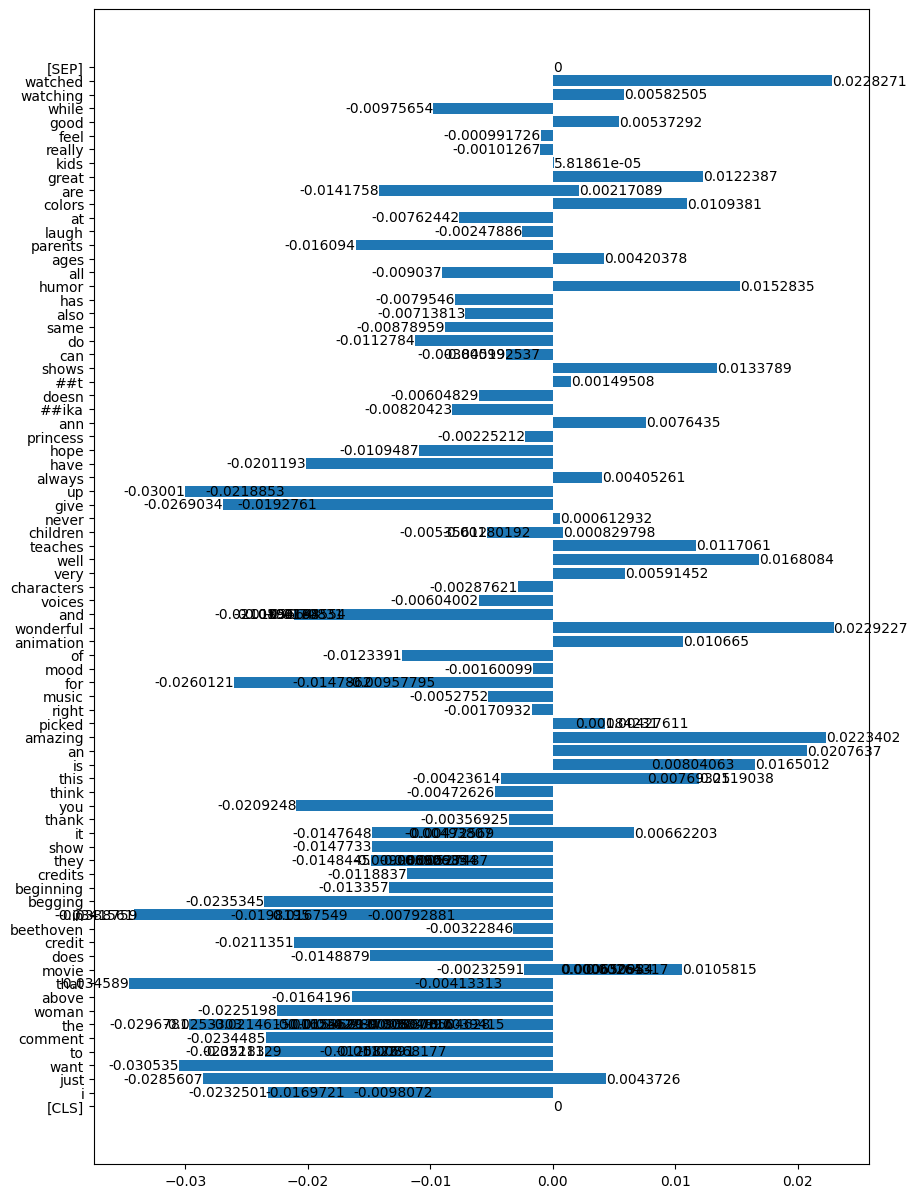

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y1)
axes.bar_label(axes.containers[0])
plt.show()

In [ ]:
# x2 = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y2 = norm_posData_negProj[0]

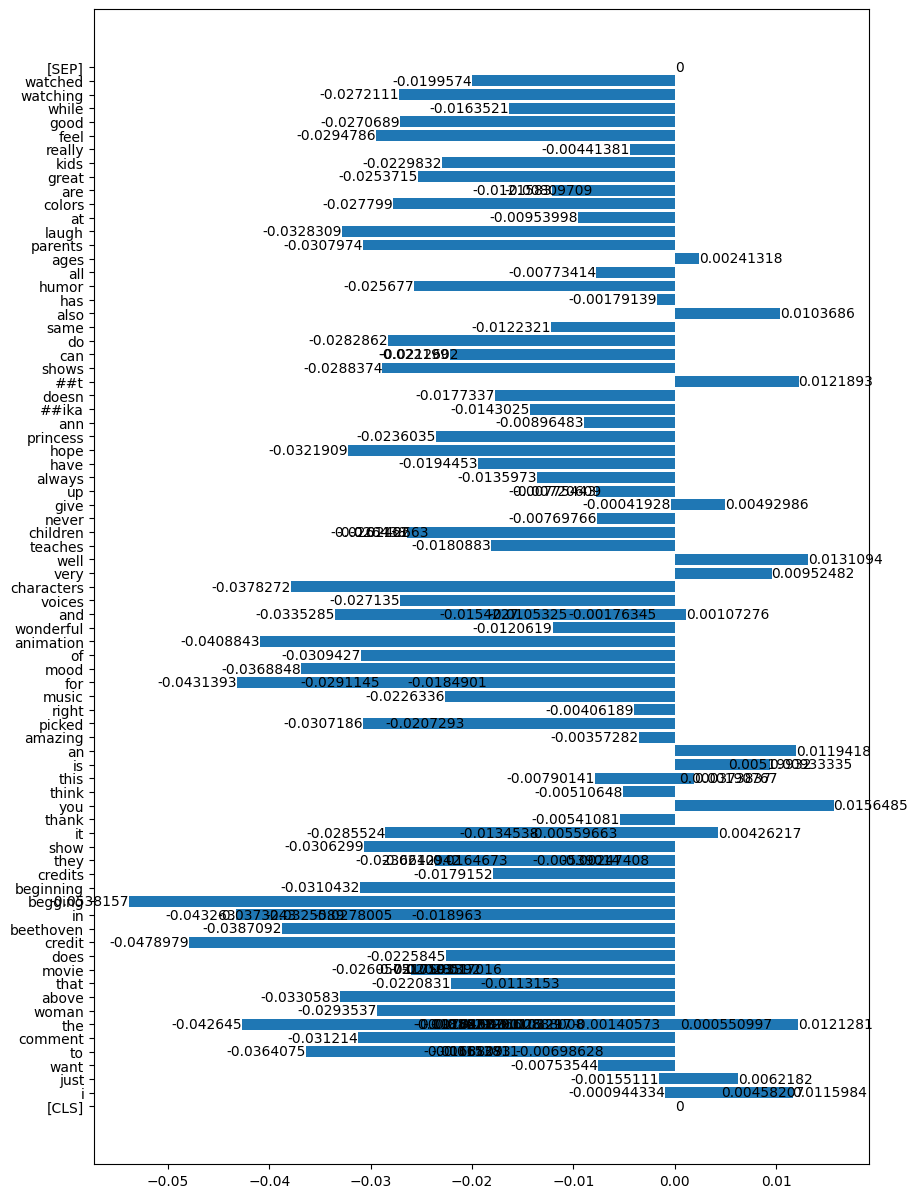

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y2)
axes.bar_label(axes.containers[0])
plt.show()

In [ ]:
for i in range(len(x)):
  print(x[i],y1[i],y2[i])
  print(x[i], y1[i] - y2[i])
  print("*"*10)

[CLS] 0.0 0.0
[CLS] 0.0
**********
i -0.016972076 0.004582065
i -0.021554142
**********
just -0.028560657 0.006218204
just -0.03477886
**********
want -0.030535031 -0.00753544
want -0.022999592
**********
to -0.023518283 -0.0069862814
to -0.016532002
**********
comment -0.023448488 -0.03121398
comment 0.0077654924
**********
to -0.022112865 -0.016127268
to -0.005985597
**********
the -0.02967807 -0.016212892
the -0.013465179
**********
woman -0.022519842 -0.029353678
woman 0.0068338364
**********
above -0.01641964 -0.033058267
above 0.016638627
**********
that -0.034588963 -0.011315316
that -0.023273647
**********
the -0.014228905 -0.015076583
the 0.00084767863
**********
movie -0.0023259104 -0.026057515
movie 0.023731604
**********
does -0.014887869 -0.022584474
does 0.0076966044
**********
credit -0.021135053 -0.047897916
credit 0.026762864
**********
beethoven -0.0032284588 -0.038709186
beethoven 0.035480727
**********
in -0.033875875 -0.037324272
in 0.003448397
**********
the -0.02

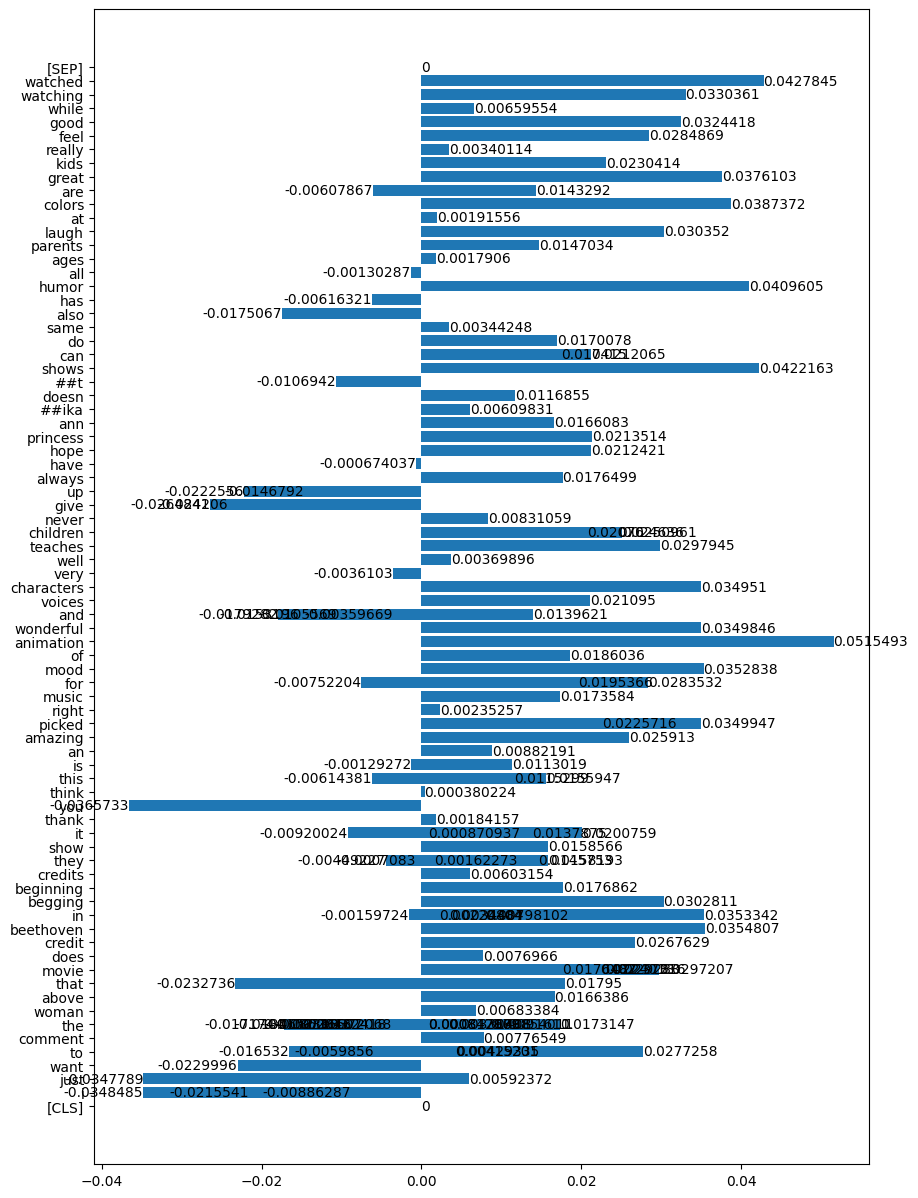

In [ ]:
y = y1 - y2

fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y)
axes.bar_label(axes.containers[0])
plt.show()

In [ ]:
print(y)

[ 0.         -0.02155414 -0.03477886 -0.02299959 -0.016532    0.00776549
 -0.0059856  -0.01346518  0.00683384  0.01663863 -0.02327365  0.00084768
  0.0237316   0.0076966   0.02676286  0.03548073  0.0034484   0.01731469
  0.03028114 -0.00159724 -0.00372068  0.01768618  0.00603154  0.00162273
  0.01585664  0.01378755  0.00184157 -0.03657332 -0.0348485   0.00038022
  0.01152994  0.01130193  0.00882191  0.025913    0.02972072 -0.00449227
  0.02257158  0.00592372  0.0091611   0.00235257  0.0173584   0.02835315
  0.00854011  0.0352838   0.01860363  0.00081298  0.02292828 -0.00862816
  0.05154928 -0.00129272  0.03498458 -0.01531964 -0.0007083   0.03499471
  0.00331408  0.02109497 -0.00752204 -0.00736607  0.03495097 -0.0036103
  0.00369896 -0.00920024  0.02979446  0.02509611  0.00429335  0.00831059
 -0.02420601 -0.01467923 -0.00359669  0.00415201  0.01764989 -0.00067404
  0.02124213  0.02135138  0.01660834  0.00609831  0.01168545 -0.01069418
 -0.02648415 -0.02225557 -0.01792821  0.02007586  0.

### MaxCosineSimilarities

In [ ]:
# normalized vectors for positive projection space
norm_posData_posProj = posData_posProjSpace.max(axis= -1)
norm_posData_negProj = posData_negProjSpace.max(axis= -1)

In [ ]:
x = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y1 = norm_posData_posProj[0]

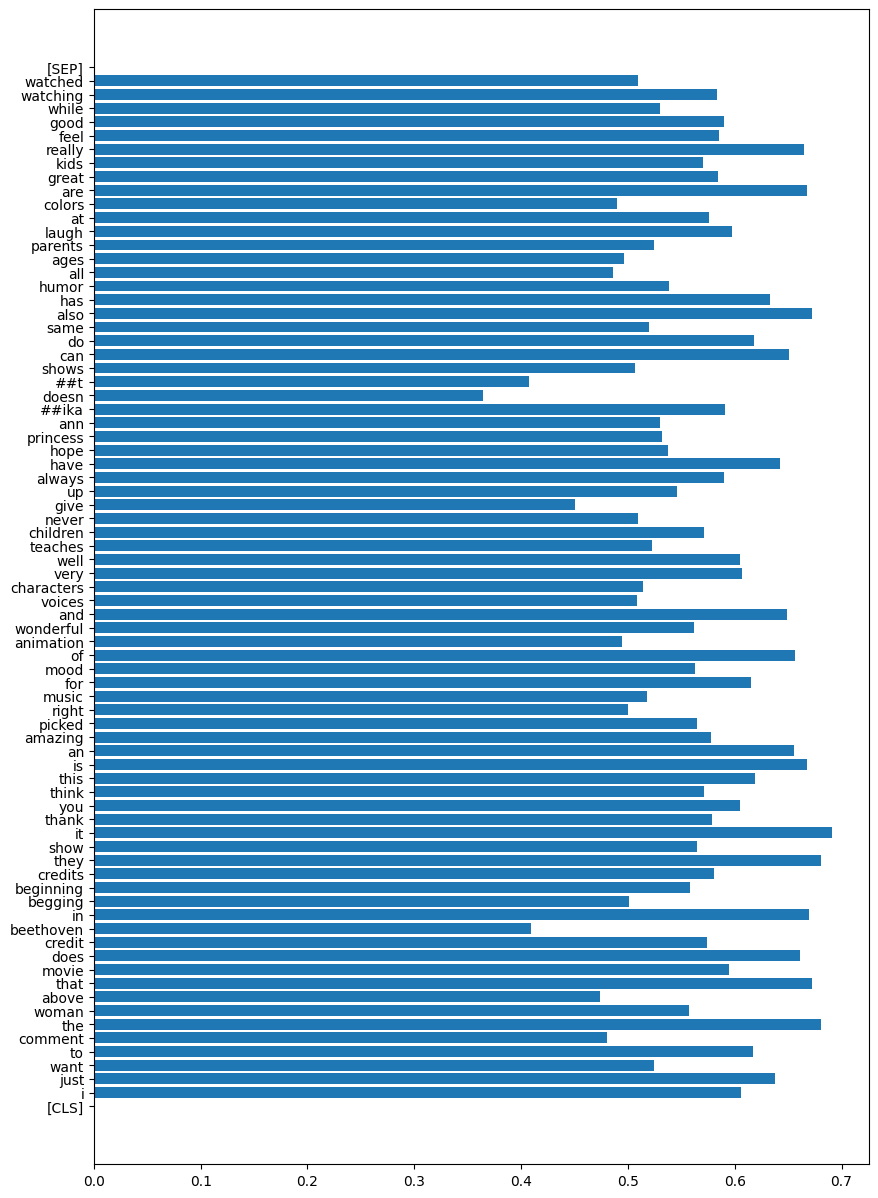

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y1)
plt.show()

In [ ]:
y2 = norm_posData_negProj[0]

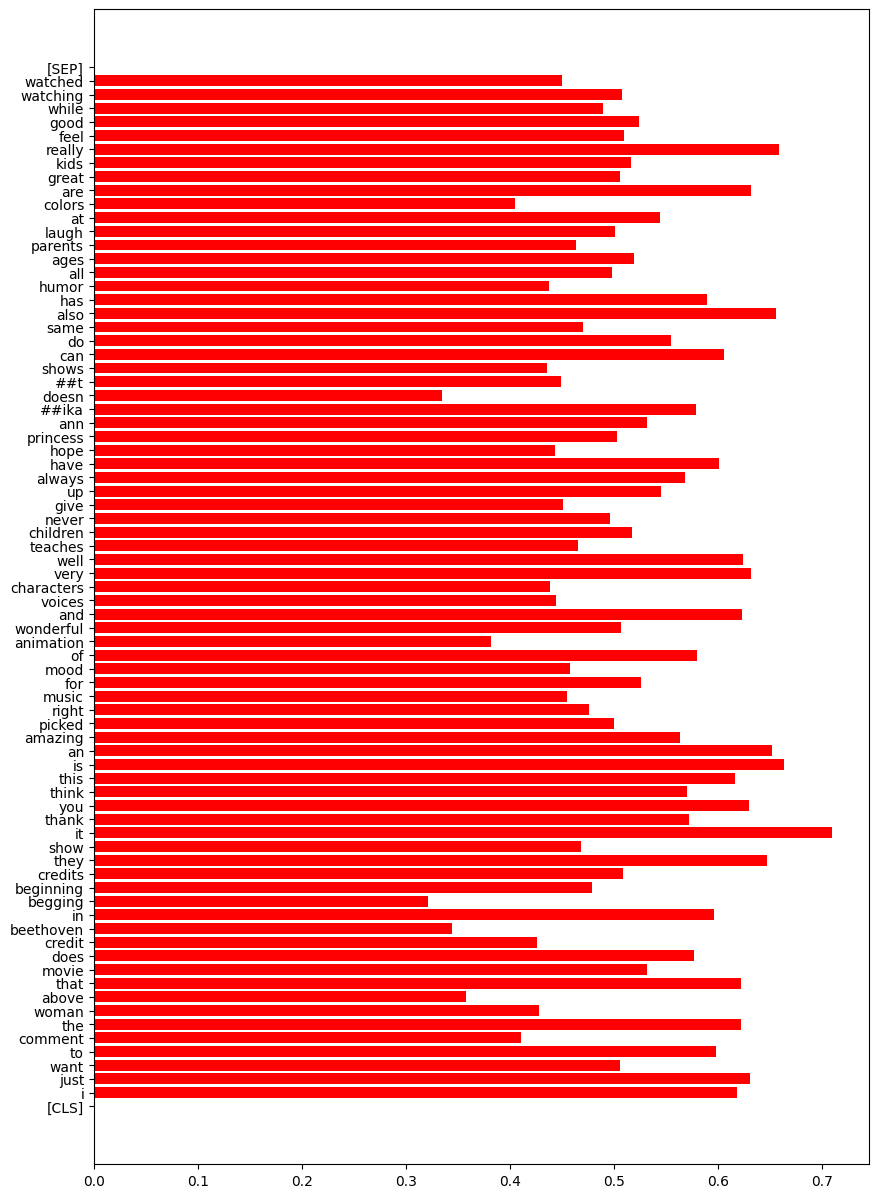

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y2, color = "red")
plt.show()

In [ ]:
t_pos[0]["input_ids"]

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  1045,  2074, ...,  3427,  2023,   102],
       [  101,  2412,  2144, ...,  1998,  1997,   102],
       [  101,  2034,  2125, ...,  2028,  2838,   102],
       ...,
       [  101, 11430,  2358, ..., 16827,  1996,   102],
       [  101,  2178,  2742, ...,     0,     0,     0],
       [  101,  2123,  2102, ...,  2228,  1996,   102]], dtype=int32)>

In [ ]:
pos_reviews.iloc[0]

review       i just want to comment to the woman above that...
sentiment                                                  1.0
Name: 0, dtype: object

In [ ]:
print(tokenizer.batch_decode(t_pos[0]["input_ids"][0]))

['[CLS]', 'i', 'just', 'want', 'to', 'comment', 'to', 'the', 'woman', 'above', 'that', 'the', 'movie', 'does', 'credit', 'beethoven', 'in', 'the', 'begging', 'in', 'the', 'beginning', 'credits', 'they', 'show', 'it', 'thank', 'you', 'i', 'think', 'this', 'is', 'an', 'amazing', 'movie', 'they', 'picked', 'just', 'the', 'right', 'music', 'for', 'the', 'mood', 'of', 'the', 'movie', 'the', 'animation', 'is', 'wonderful', 'and', 'they', 'picked', 'the', 'voices', 'for', 'the', 'characters', 'very', 'well', 'it', 'teaches', 'children', 'to', 'never', 'give', 'up', 'and', 'to', 'always', 'have', 'hope', 'princess', 'ann', '##ika', 'doesn', '##t', 'give', 'up', 'and', 'it', 'shows', 'children', 'that', 'they', 'can', 'do', 'the', 'same', 'the', 'movie', 'also', 'has', 'humor', 'in', 'in', 'for', 'all', 'ages', 'parents', 'and', 'children', 'to', 'laugh', 'at', 'the', 'colors', 'in', 'this', 'movie', 'are', 'great', 'and', 'kids', 'can', 'really', 'feel', 'good', 'while', 'they', 'are', 'watchi

In [ ]:
posData_posProjSpace[0]

array([[ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.00470075,  0.24290948, -0.3253671 , ...,  0.07412781,
         0.3223575 , -0.3271877 ],
       [-0.01312553,  0.509873  , -0.5854764 , ...,  0.11545158,
         0.587902  , -0.58453995],
       ...,
       [ 0.13661043,  0.44075522, -0.510349  , ...,  0.20855941,
         0.5091398 , -0.5090423 ],
       [ 0.08732635,  0.53262544, -0.5841105 , ...,  0.1892705 ,
         0.5874502 , -0.5833038 ],
       [ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        , -0.        ]], dtype=float32)

In [ ]:
negData_negProjSpace.shape

(100, 128, 10)

In [ ]:
# positive samples with positive projection space, take mean 
# then take maximum of means of words - Which word is that

In [ ]:
posData_posProjSpace.shape

(100, 128, 10)

In [ ]:
negData_negProjSpace.shape

(100, 128, 10)

In [ ]:
def AverageSentenceEmbedding(matrix):


  Length = tf.math.count_nonzero(tf.math.reduce_sum(matrix, axis=2,keepdims=True), axis=1, keepdims=True,dtype = np.float32)   # (None,1,1)

  # now obtain average of cosine similarities
  matrixSum = np.sum(matrix,axis=1, keepdims=True)    # (None,1,300)
  matrixAverage = np.divide(matrixSum, Length)


  return matrixAverage

In [ ]:
posProjectionSpace  = AverageSentenceEmbedding(posData_posProjSpace)
negProjectionSpace = AverageSentenceEmbedding(posData_negProjSpace)

In [ ]:
# we have access to each sentence's input ids, as well as their bert embeddings right now
# we want to see which tokens from a sentence have maximum cosine similarity with pos_projection space
# get those indices, and we have those token ids
# now we want to fetch the words corresponding to those token ids

In [ ]:
np.squeeze(posProjectionSpace).shape

(100, 10)

In [ ]:
from sklearn.manifold import TSNE
m = TSNE(n_components=2, learning_rate= 50,
                   init='pca', perplexity=3, n_iter= 2500)

In [ ]:
combined = np.vstack([np.squeeze(posProjectionSpace), np.squeeze(negProjectionSpace)])

In [ ]:
combined.shape

(200, 10)

In [ ]:
tSNE_combined = m.fit_transform(combined)

In [ ]:
tSNE_combined.shape

(200, 2)

In [ ]:
t_pos

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  1045,  2074, ...,  3427,  2023,   102],
         [  101,  2412,  2144, ...,  1998,  1997,   102],
         [  101,  2034,  2125, ...,  2028,  2838,   102],
         ...,
         [  101, 11430,  2358, ..., 16827,  1996,   102],
         [  101,  2178,  2742, ...,     0,     0,     0],
         [  101,  2123,  2102, ...,  2228,  1996,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 10), dtype=int32, numpy=
  array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 

In [ ]:
t_neg

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  2007,  1037, ...,     0,     0,     0],
         [  101,  1045,  3685, ...,  3185,  2323,   102],
         [  101,  2053,  3043, ...,  7987, 15056,   102],
         ...,
         [  101,  2092,  2023, ...,  2008,  2001,   102],
         [  101,  2821,  6203, ...,  2032,  2019,   102],
         [  101,  2108,  1037, ..., 18251,  1037,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 10), dtype=int32, numpy=
  array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 

In [ ]:
# tokens
posData_posProjSpace[0].shape

(128, 10)

In [ ]:
pos_reviews.review.values[0]

'i just want to comment to the woman above that the movie does credit beethoven in the begging in the beginning credits they show it thank you i think this is an amazing movie they picked just the right music for the mood of the movie the animation is wonderful and they picked the voices for the characters very well it teaches children to never give up and to always have hope princess annika doesnt give up and it shows children that they can do the same the movie also has humor in in for all ages parents and children to laugh at the colors in this movie are great and kids can really feel good while they are watching it i watched this movie for the first time now i am a huge fan and im sure your child will be too walmart sells tons of barbie and the magic of pegasus stuff so your child can continue to enjoy the movie even when they arent watching it thank you'

In [ ]:
wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.1)
wordidx[0]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126])

In [ ]:
t_pos[0]["input_ids"][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1045,  2074,  2215,  2000,  7615,  2000,  1996,  2450,
        2682,  2008,  1996,  3185,  2515,  4923, 15461,  1999,  1996,
       12858,  1999,  1996,  2927,  6495,  2027,  2265,  2009,  4067,
        2017,  1045,  2228,  2023,  2003,  2019,  6429,  3185,  2027,
        3856,  2074,  1996,  2157,  2189,  2005,  1996,  6888,  1997,
        1996,  3185,  1996,  7284,  2003,  6919,  1998,  2027,  3856,
        1996,  5755,  2005,  1996,  3494,  2200,  2092,  2009, 12011,
        2336,  2000,  2196,  2507,  2039,  1998,  2000,  2467,  2031,
        3246,  4615,  5754,  7556,  2987,  2102,  2507,  2039,  1998,
        2009,  3065,  2336,  2008,  2027,  2064,  2079,  1996,  2168,
        1996,  3185,  2036,  2038,  8562,  1999,  1999,  2005,  2035,
        5535,  3008,  1998,  2336,  2000,  4756,  2012,  1996,  6087,
        1999,  2023,  3185,  2024,  2307,  1998,  4268,  2064,  2428,
        2514,  2204,  2096,  2027,  2024,  3

In [ ]:
print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[0])

[CLS]


In [ ]:
posData_posProjSpace[0]

array([[ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.00470075,  0.24290948, -0.3253671 , ...,  0.07412781,
         0.3223575 , -0.3271877 ],
       [-0.01312553,  0.509873  , -0.5854764 , ...,  0.11545158,
         0.587902  , -0.58453995],
       ...,
       [ 0.13661043,  0.44075522, -0.510349  , ...,  0.20855941,
         0.5091398 , -0.5090423 ],
       [ 0.08732635,  0.53262544, -0.5841105 , ...,  0.1892705 ,
         0.5874502 , -0.5833038 ],
       [ 0.        ,  0.        , -0.        , ...,  0.        ,
         0.        , -0.        ]], dtype=float32)

In [ ]:
for index in wordidx[0]:

  print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index], end = " ")

i just want to comment to the woman above that the movie does credit beethoven in the begging in the beginning credits they show it thank you i think this is an amazing movie they picked just the right music for the mood of the movie the animation is wonderful and they picked the voices for the characters very well it teaches children to never give up and to always have hope princess ann ##ika doesn ##t give up and it shows children that they can do the same the movie also has humor in in for all ages parents and children to laugh at the colors in this movie are great and kids can really feel good while they are watching it i watched this 

In [ ]:
wordidx

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126]),)

In [ ]:
wordidx = np.max(negData_negProjSpace[0], axis = 1)

for index, value in enumerate(wordidx):

  print(tokenizer.batch_decode(t_neg[0]["input_ids"][0])[index], value)

[CLS] 0.0
with 0.46334472
a 0.57299614
little 0.52917314
dressing 0.43999422
up 0.6221309
this 0.66149086
movie 0.51667774
could 0.5450692
be 0.5507292
served 0.4619224
for 0.49722603
thanksgiving 0.45024797
dinner 0.53462523
not 0.471166
only 0.5691903
is 0.66069674
is 0.552683
boring 0.4873878
imp 0.6303518
##laus 0.5797413
##ible 0.64662504
historically 0.5882788
inaccurate 0.5814376
and 0.61858284
poorly 0.5379278
directed 0.5461757
the 0.633602
best 0.5227549
actors 0.5301536
were 0.61666673
the 0.595844
bit 0.48741758
players 0.6056345
mainly 0.5921129
because 0.5561758
they 0.58172315
had 0.58678395
so 0.53487253
few 0.5176759
lines 0.4565386
to 0.49980247
say 0.4065874
a 0.65300167
waste 0.5053643
of 0.636703
time 0.56727785
even 0.5587583
for 0.52656585
war 0.45806742
fan 0.535105
##atics 0.55479443
[SEP] -0.0
[PAD] -0.0
[PAD] -0.0
[PAD] -0.0
[PAD] -0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] -0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD

In [ ]:
'''
in pos space: words with higher positive polarity will show up - opposite behaviour in negative space and vice versa

for each threshold - get sum of polarities of all words (for 100 sentences)

'''
print()

In [ ]:
# imdb
# hatebase
# PeaceViolent public dataset?

In [ ]:
# collect communal violence dataset that occurs through social media (YT mainly). (ex Hindus vs Muslims, Veg - Non Veg)
# we have the data collection pipeline
# find what kind of communal violence took place in India / Pakistan

In [ ]:
'''

1. See how vader is used
2. Map the polarity of words from vader
3. Set some thresholds, for all the words we get --> sum up their polarities
4. Plot CosineSim Thresholds vs Sum(Polarities)

'''

'\n\n1. See how vader is used\n2. Map the polarity of words from vader\n3. Set some thresholds, for all the words we get --> sum up their polarities\n4. Plot CosineSim Thresholds vs Sum(Polarities)\n\n'

In [ ]:
# words with max cosine > 0.25
wordidx = np.where(np.max(negData_negProjSpace[0], axis = 1) > 0.15)

for index in wordidx[0]:

  print(tokenizer.batch_decode(t_neg[0]["input_ids"][0])[index])

with
a
little
dressing
up
this
movie
could
be
served
for
thanksgiving
dinner
not
only
is
is
boring
imp
##laus
##ible
historically
inaccurate
and
poorly
directed
the
best
actors
were
the
bit
players
mainly
because
they
had
so
few
lines
to
say
a
waste
of
time
even
for
war
fan
##atics


## tSNE - PROJECTION SPACES

### Positive Data

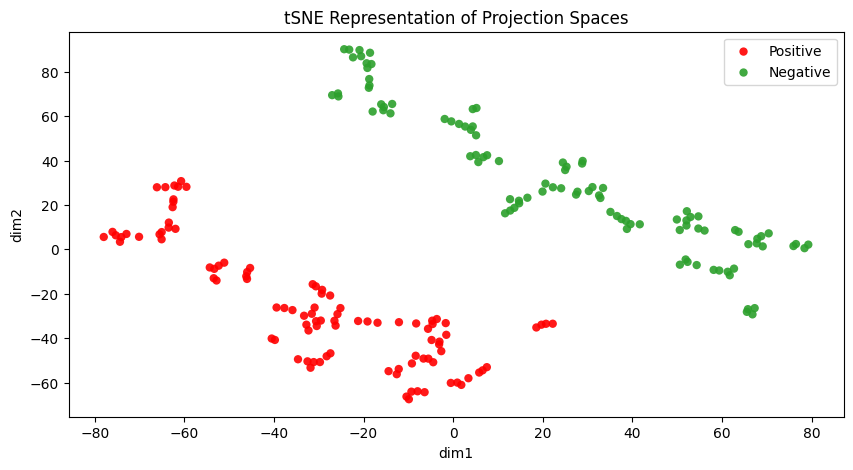

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

for color in ['RED', 'tab:GREEN']:
    n = 750
    if color == "RED":
      x, y = tSNE_combined[:100,0], tSNE_combined[:100,1]

    else:
      x, y = tSNE_combined[100:,0], tSNE_combined[100:,1]

    ax.scatter(x, y, c=color, label= "Positive" if color == "RED" else "Negative",
               alpha=0.9, edgecolors='none')

ax.legend()
ax.set_xlabel("dim1")
ax.set_ylabel("dim2")
ax.set_title("tSNE Representation of Projection Spaces")

plt.show()

### Negative Data

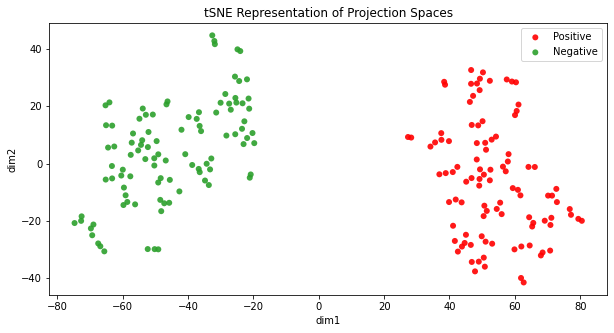

In [ ]:
# for negative projection space
fig, ax = plt.subplots(figsize = (10,5))

for color in ['RED', 'tab:GREEN']:
    n = 750
    if color == "RED":
      x, y = tSNE_combined[:100,0], tSNE_combined[:100,1]

    else:
      x, y = tSNE_combined[100:,0], tSNE_combined[100:,1]

    ax.scatter(x, y, c=color, label= "Positive" if color == "RED" else "Negative",
               alpha=0.9, edgecolors='none')

ax.legend()
ax.set_xlabel("dim1")
ax.set_ylabel("dim2")
ax.set_title("tSNE Representation of Projection Spaces")

plt.show()

## VADER POLARITY

In [ ]:
# !unzip "/gdrive/Shareddrives/Thesis/code/Rahul/vaderSentiment-master.zip" -d "/gdrive/Shareddrives/Thesis/code/Rahul/"

In [ ]:
df_sent = pd.read_csv("/gdrive/Shareddrives/Thesis/code/Rahul/vaderSentiment-master/vaderSentiment/vader_lexicon.txt", sep = "\t", header = None)

In [ ]:
df_sent.columns = ["token", "sentiment", "stdev", "values"]
df_sent.head()

,token,sentiment,stdev,values
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [ ]:
sent_dict = dict()
for tok, sent in zip(df_sent.token.values,df_sent.sentiment.values) :
  sent_dict[tok] = sent

In [ ]:
sent_dict["to"]

KeyError: ignored

In [ ]:
# words with max cosine > 0.25
wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.25)

tokens1 = list()
for index in wordidx[0]:

  tokens1.append(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])
  # print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])

In [ ]:
print(tokens1)

NameError: ignored

In [ ]:
polarity025 = 0.0
for ele in tokens1:
  polarity025 += sent_dict.get(ele,0)

In [ ]:
polarity005, polarity010, polarity015, polarity020, polarity021, polarity025

(10.4, 10.4, 10.4, 1.5, 0.0, 0.0)

In [ ]:
# words with max cosine > 0.25
# wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.25)
# now with negative projection space
sentence = 0
negs_tokens20 = dict()
while sentence < 32:
  wordidx = np.where(np.max(posData_negProjSpace[sentence], axis = 1) > 0.20)
  tokens1 = list()
  for index in wordidx[0]:

    tokens1.append(tokenizer.batch_decode(t_pos[0]["input_ids"][sentence])[index])
    # print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])
  negs_tokens20[sentence] = tokens1
  print(sentence)
  sentence +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [ ]:
# s_tokens has tokens with offset of 0.05
# s_tokens10, negs_tokens10 - Done
# s_tokens15, negs_tokens15 - Done
# s_tokens20, negs_tokens20
# s_tokens35

In [ ]:
# negs_tokens10

In [ ]:
# s_tokens10, polarity10 - Done
# s_tokens15, polarity15 - Done
# s_tokens20, polarity20 - Done

# negs_tokens10, neg_polarity10 - Done
# negs_tokens15, neg_polarity15 -> error :(


In [ ]:
polarity20 = dict()
for sentence in s_tokens20:
  p005 = 0.0
  for token in s_tokens20[sentence]:
    p005 += sent_dict.get(token,0)
  polarity20[sentence] = p005

In [ ]:
# negsentence polarity
neg_polarity20 = dict()
for sentence in negs_tokens20:
  p005 = 0.0
  for token in negs_tokens20[sentence]:
    p005 += sent_dict.get(token,0)
  neg_polarity20[sentence] = p005

In [ ]:
polarity010

In [ ]:
polarity015

In [ ]:
polarity20

In [ ]:
neg_polarity10

In [ ]:
neg_polarity15

In [ ]:
neg_polarity20

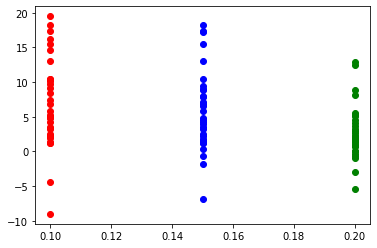

In [ ]:
for polarity in polarity010:
  plt.scatter(0.10,polarity010[polarity], color = "red")

for polarity in polarity015:
  plt.scatter(0.15,polarity015[polarity], color = "blue")

for polarity in polarity20:
  plt.scatter(0.20,polarity20[polarity], color = "green")
plt.show()

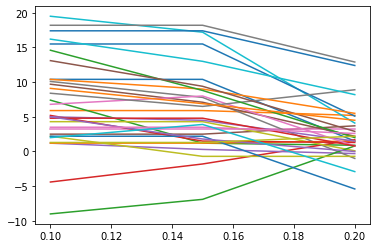

In [ ]:

for s_index in range(32):
  x = [0.10,0.15,0.20]
  y = [polarity010[s_index],polarity015[s_index],polarity20[s_index]]
  plt.plot(x,y)
plt.show()

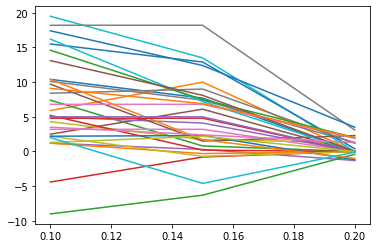

In [ ]:
for s_index in range(32):
  x = [0.10,0.15,0.20]
  y = [neg_polarity10[s_index],neg_polarity15[s_index],neg_polarity20[s_index]]
  plt.plot(x,y)
plt.show()

In [ ]:
s_tokens20

{0: ['to',
  'comment',
  'to',
  'the',
  'in',
  'in',
  'the',
  'beginning',
  'show',
  'thank',
  'you',
  'i',
  'the',
  'mood',
  'the',
  'and'],
 1: ['##s',
  'it',
  'i',
  'have',
  'on',
  'this',
  'under',
  'emmy',
  'her',
  'portrayal',
  'here',
  'is',
  '##des',
  'is',
  'masterpiece',
  'of',
  '##sta',
  '##tem',
  'shine',
  '##s',
  'this',
  'was',
  '##ignant',
  'for',
  'for',
  'grew',
  'up',
  'detail',
  'phenomena',
  '##l',
  'and',
  'ev',
  'woo',
  '##oo',
  '##oo',
  '##ond',
  '##ful',
  'life',
  'times'],
 2: ['im',
  '##t',
  'any',
  'im',
  '##db',
  'yet',
  'from',
  'a',
  'us',
  'viewer',
  'secondly',
  'in',
  'so',
  'in',
  'of',
  'comes',
  'american',
  'programming',
  'one',
  'is',
  'example',
  'of',
  'television',
  'to',
  'would',
  'script',
  '##ing',
  'feature',
  'namely',
  'those',
  'made',
  'by',
  '##eurs',
  'who',
  'had',
  'to',
  'make',
  'dramas',
  'more',
  'and',
  'allow',
  'organic',
  'characte

In [ ]:
negs_tokens20

{0: ['comment',
  'to',
  'in',
  'the',
  'beginning',
  'they',
  'this',
  'mood',
  'the',
  'animation'],
 1: ['this', 'under', 'her', 'this', 'up'],
 2: ['##db',
  'example',
  'television',
  '##eurs',
  'had',
  'dramas',
  'realistic',
  'and',
  'character',
  'development',
  'tack',
  'prime',
  'under'],
 3: ['takes', 'a', 'husband', 'life'],
 4: ['##e',
  'lot',
  'film',
  'then',
  'that',
  'give',
  'film',
  'my',
  'shocked',
  'through',
  'it',
  'but',
  'of',
  'and',
  'film',
  'made',
  'watching',
  'whole',
  'fact',
  'doesn'],
 5: ['keep',
  'this',
  'thought',
  'my',
  'what',
  'minutes',
  'after',
  'jaw',
  'the',
  'is',
  'can',
  'furthermore',
  'this',
  'candy',
  'style',
  'although',
  'at',
  '##t'],
 6: ['[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 7: ['movie',
  'very',
  'fan',
  'an',
  'had',
  'it',
  '##s',
  'of',
  'it',
  'terribly',
  'romance'],
 8: ['original', 'bar'],
 9:

In [ ]:
[(sent,pol) for sent,pol in polarity010.items() if pol < 0.0]

[(3, -4.400000000000001), (12, -9.0)]

In [ ]:
[(sent,pol) for sent,pol in polarity015.items() if pol < 0.0]

[(3, -1.8000000000000007), (12, -6.8999999999999995), (18, -0.7)]

In [ ]:
[(sent,pol) for sent,pol in polarity20.items() if pol < 0.0]

[(4, -0.30000000000000004),
 (7, -1.0000000000000004),
 (18, -0.7),
 (20, -5.4),
 (29, -2.9)]

In [ ]:
s_tokens10[3]

In [ ]:
np.sort(np.max(posData_posProjSpace[0], axis = 1))[::-1]

array([ 0.28367928,  0.27361298,  0.25846794,  0.2567309 ,  0.23229809,
        0.23036386,  0.22909796,  0.22841337,  0.222799  ,  0.21163484,
        0.20897613,  0.20807424,  0.20779014,  0.20567214,  0.20542979,
        0.20029488,  0.1998684 ,  0.1987663 ,  0.19853252,  0.19639128,
        0.19464648,  0.1933001 ,  0.19277774,  0.19270825,  0.19267467,
        0.19203955,  0.19176328,  0.18915385,  0.1882963 ,  0.18800393,
        0.18694088,  0.18574877,  0.18522975,  0.18468729,  0.18111327,
        0.18015519,  0.17918457,  0.17561908,  0.17444785,  0.17360322,
        0.1721769 ,  0.16864721,  0.16788839,  0.16692606,  0.16653143,
        0.16549495,  0.15814804,  0.15729396,  0.15670548,  0.15535133,
        0.1539587 , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [ ]:
np.max(posData_posProjSpace[0], axis = 1)

array([-0.        ,  0.15535133,  0.19464648,  0.19639128,  0.20567214,
        0.2567309 ,  0.25846794,  0.20779014,  0.16864721,  0.19267467,
        0.15814804,  0.15729396,  0.16788839,  0.1987663 ,  0.16692606,
        0.18468729,  0.222799  ,  0.17360322,  0.16653143,  0.23036386,
        0.20542979,  0.23229809,  0.1933001 ,  0.19277774,  0.28367928,
        0.15670548,  0.20897613,  0.22909796,  0.21163484,  0.19270825,
        0.19203955,  0.19853252,  0.17918457,  0.18111327,  0.18800393,
        0.1998684 ,  0.18694088,  0.1882963 ,  0.20029488,  0.16549495,
        0.1721769 ,  0.1539587 ,  0.18522975,  0.27361298,  0.18015519,
        0.22841337,  0.18915385,  0.19176328,  0.17561908,  0.17444785,
        0.18574877,  0.20807424, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [ ]:
wordidx = np.max(posData_posProjSpace[0], axis = 1)

for index, value in enumerate(wordidx):

  print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index], value)

[CLS] -0.0
i 0.15535133
just 0.19464648
want 0.19639128
to 0.20567214
comment 0.2567309
to 0.25846794
the 0.20779014
woman 0.16864721
above 0.19267467
that 0.15814804
the 0.15729396
movie 0.16788839
does 0.1987663
credit 0.16692606
beethoven 0.18468729
in 0.222799
the 0.17360322
begging 0.16653143
in 0.23036386
the 0.20542979
beginning 0.23229809
credits 0.1933001
they 0.19277774
show 0.28367928
it 0.15670548
thank 0.20897613
you 0.22909796
i 0.21163484
think 0.19270825
this 0.19203955
is 0.19853252
an 0.17918457
amazing 0.18111327
movie 0.18800393
they 0.1998684
picked 0.18694088
just 0.1882963
the 0.20029488
right 0.16549495
music 0.1721769
for 0.1539587
the 0.18522975
mood 0.27361298
of 0.18015519
the 0.22841337
movie 0.18915385
the 0.19176328
animation 0.17561908
is 0.17444785
wonderful 0.18574877
and 0.20807424
they -0.0
picked -0.0
the -0.0
voices -0.0
for -0.0
the -0.0
characters -0.0
very -0.0
well -0.0
it -0.0
teaches -0.0
children -0.0
to -0.0
never -0.0
give -0.0
up -0.0
and

#### tSNE Projection Spaces -> Negative Data